# Case Study Notebook

This notebook shows the case study for the paper "OptMSP: A Toolbox for Designing Optimal Multi-Stage (Bio)Processes". The parameters used in the models are from [Wichmann *et al.*](https://doi.org/10.1016/j.ymben.2023.04.006).

Time to execute all cells: 

In [1]:
### Import packages
import polars as pl
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import itertools
from collections import Counter

# For plotting
import seaborn as sns

sns.set_theme(style="ticks")
sns.axes_style("darkgrid")
sns.set_theme()

from IPython.display import display, HTML

# For storing DataFrames
import pickle

import sys
from os import getcwd
sys.path.append(getcwd())
import MultiStagePackage.OptMSPfunctions as msp
from MultiStagePackage.models import *

from itertools import islice
import collections
from ast import literal_eval

# For optimization
from pygmo import *

In [2]:
### Prepare data

# initial conditions
X_0 = 0.1    # gDW/L
S_0 = 100.0  # mmol/L => max theoret c atoms for production = 6 atoms * S_0 (e.g.=100) = 600 c-atoms => 85% = 510
P_0 = 0.0    # mmol/L
s = np.array([X_0, S_0, P_0])

# Indexing
X, S, P = (i for i in range(len(s)))
r_S, r_P, mu = (i for i in range(3))

## Models

If the models are not directly defined in the cell then the following order and number of models was used:

In [3]:
models_numeric = [WT_aerob_growth,
                 WT_anaerob_growth, 
                 WT_anaerob_growth_arrest,
                 LC_aerob_growth,
                 LC_anaerob_growth, 
                 LC_anaerob_growth_arrest]

models_analytic = [WT_aerob_growth_analyt,
                 WT_anaerob_growth_analyt, 
                 WT_anaerob_growth_arrest_analyt,
                 LC_aerob_growth_analyt,
                 LC_anaerob_growth_analyt, 
                 LC_anaerob_growth_arrest_analyt]

## One-Stage fermentation dynamics and simulation output

### Brute force

,Index,Times,Models,End_T,End_X,End_S,End_P,finished,Vol_P,Y_SubInput,Y_SubUsed
0,1,"(0.0, 24.0)",[1],8.15,6.92,-0.00,1.57,1,0.19,0.02,0.02
1,2,"(0.0, 24.0)",[2],16.95,0.91,0.00,161.87,1,9.55,1.62,1.62
2,3,"(0.0, 24.0)",[3],24.00,0.10,97.94,3.41,inf,0.14,0.03,1.65
3,4,"(0.0, 24.0)",[4],8.84,8.32,0.00,1.32,1,0.15,0.01,0.01
4,5,"(0.0, 24.0)",[5],21.46,0.36,0.00,180.45,1,8.41,1.80,1.80
5,6,"(0.0, 24.0)",[6],24.00,0.10,77.51,42.26,inf,1.76,0.42,1.88


,Index,Times,Models,End_T,End_X,End_S,End_P,finished,Vol_P,Y_SubInput,Y_SubUsed
1,2,"(0.0, 24.0)",[2],16.95,0.91,0.0,161.87,1,9.55,1.62,1.62


CPU times: user 1.88 s, sys: 213 ms, total: 2.09 s
Wall time: 1.83 s


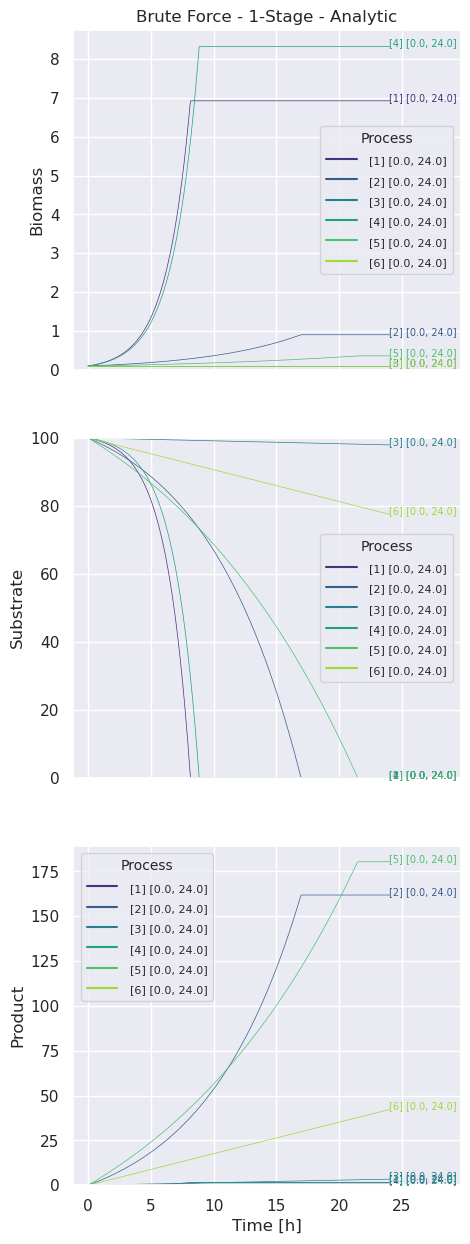

In [4]:
%%time
t_start = 0
t_end = 24
min_duration = 1
n_stages = 1
combis = [[0], [1], [2], [3], [4], [5]]

BruteForceAnalyt_1Stage = msp.do_brute_force_ana(combis, models_analytic, n_stages, t_start, t_end, min_duration, s)
display(BruteForceAnalyt_1Stage)

BruteForceAnalyt_1Stage_best = (BruteForceAnalyt_1Stage.sort_values(["Vol_P"], ascending=[False]).dropna(axis=0).drop_duplicates(subset="Models", keep="first")[:1])
display(BruteForceAnalyt_1Stage_best)

msp.do_custom_plot(df=BruteForceAnalyt_1Stage, models_num=models_numeric, s=s, title="Brute Force - 1-Stage - Analytic")

___

# Brute Force

## Two-Stage fermentation  - Analytic
(could be seen as strain comparison)

With density = 4 in paper denoted as ($t_{step}$=0.25h)

,Index,Times,Models,End_T,End_X,End_S,End_P,finished,Vol_P,Y_SubInput,Y_SubUsed
0,1,"(0.0, 1.0, 24.0)","[1, 1]",8.15,6.92,-0.00,1.57,2,0.19,0.02,0.02
1,2,"(0.0, 1.25, 24.0)","[1, 1]",8.15,6.92,0.00,1.57,2,0.19,0.02,0.02
2,3,"(0.0, 1.5, 24.0)","[1, 1]",8.15,6.92,0.00,1.57,2,0.19,0.02,0.02
3,4,"(0.0, 1.75, 24.0)","[1, 1]",8.15,6.92,0.00,1.57,2,0.19,0.02,0.02
4,5,"(0.0, 2.0, 24.0)","[1, 1]",8.15,6.92,0.00,1.57,2,0.19,0.02,0.02
...,...,...,...,...,...,...,...,...,...,...,...
547,548,"(0.0, 22.0, 24.0)","[3, 3]",24.00,0.10,97.94,3.41,inf,0.14,0.03,1.65
548,549,"(0.0, 22.25, 24.0)","[3, 3]",24.00,0.10,97.94,3.41,inf,0.14,0.03,1.65
549,550,"(0.0, 22.5, 24.0)","[3, 3]",24.00,0.10,97.94,3.41,inf,0.14,0.03,1.65
550,551,"(0.0, 22.75, 24.0)","[3, 3]",24.00,0.10,97.94,3.41,inf,0.14,0.03,1.65


,Index,Times,Models,End_T,End_X,End_S,End_P,finished,Vol_P,Y_SubInput,Y_SubUsed
44,45,"(0.0, 4.5, 24.0)","[1, 2]",8.44,1.73,0.0,139.84,2,16.56,1.4,1.4


CPU times: user 1.02 s, sys: 154 ms, total: 1.18 s
Wall time: 953 ms


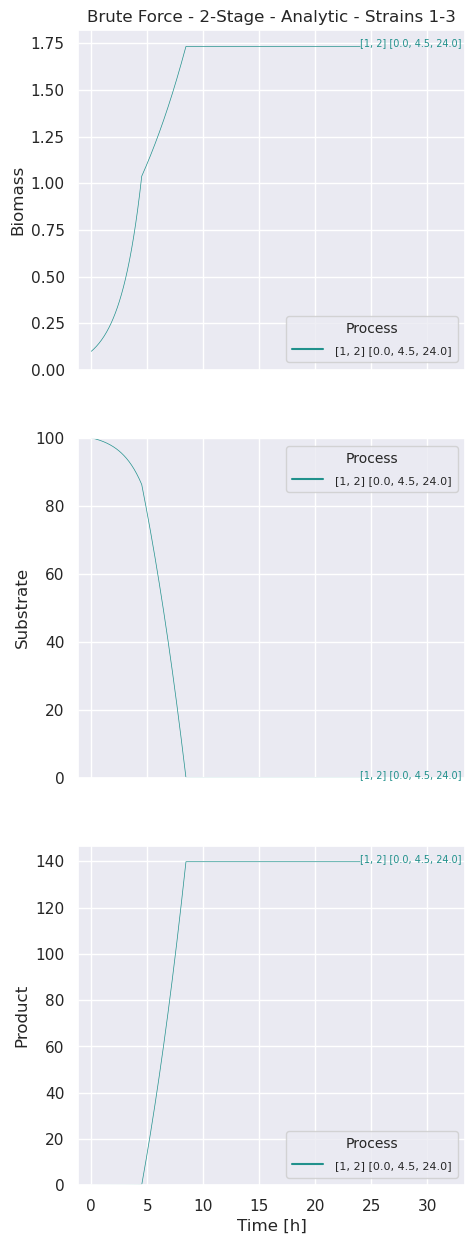

In [5]:
%%time
t_start = 0
t_end = 24
min_duration = 1
n_stages = 2
den = 4
combis = list(itertools.product([0, 1, 2], [0, 1, 2]))  

BruteForceAnalytic_2Stage_Ecolac = msp.do_brute_force_ana(combis, models_analytic, n_stages, t_start, t_end, min_duration, s, den)
display(BruteForceAnalytic_2Stage_Ecolac)
#msp.do_save(BruteForceAnalytic_2Stage_Ecolac, './Results/Computer_Stg2_ana_brf_1to3_den4.pickle')

BruteForceAnalytic_2Stage_Ecolac_best = (BruteForceAnalytic_2Stage_Ecolac.sort_values(["Vol_P"], ascending=[False]).dropna(axis=0).drop_duplicates(subset="Models", keep="first")[:1])
display(BruteForceAnalytic_2Stage_Ecolac_best)
msp.do_custom_plot(df=BruteForceAnalytic_2Stage_Ecolac_best, models_num=models_numeric, s=s, title="Brute Force - 2-Stage - Analytic - Strains 1-3")

,Index,Times,Models,End_T,End_X,End_S,End_P,finished,Vol_P,Y_SubInput,Y_SubUsed
0,1,"(0.0, 1.0, 24.0)","[4, 4]",8.84,8.32,0.00,1.32,2,0.15,0.01,0.01
1,2,"(0.0, 1.25, 24.0)","[4, 4]",8.84,8.32,0.00,1.32,2,0.15,0.01,0.01
2,3,"(0.0, 1.5, 24.0)","[4, 4]",8.84,8.32,0.00,1.32,2,0.15,0.01,0.01
3,4,"(0.0, 1.75, 24.0)","[4, 4]",8.84,8.32,0.00,1.32,2,0.15,0.01,0.01
4,5,"(0.0, 2.0, 24.0)","[4, 4]",8.84,8.32,0.00,1.32,2,0.15,0.01,0.01
...,...,...,...,...,...,...,...,...,...,...,...
610,611,"(0.0, 22.0, 24.0)","[6, 6]",24.00,0.10,77.51,42.26,inf,1.76,0.42,1.88
611,612,"(0.0, 22.25, 24.0)","[6, 6]",24.00,0.10,77.51,42.26,inf,1.76,0.42,1.88
612,613,"(0.0, 22.5, 24.0)","[6, 6]",24.00,0.10,77.51,42.26,inf,1.76,0.42,1.88
613,614,"(0.0, 22.75, 24.0)","[6, 6]",24.00,0.10,77.51,42.26,inf,1.76,0.42,1.88


,Index,Times,Models,End_T,End_X,End_S,End_P,finished,Vol_P,Y_SubInput,Y_SubUsed
48,49,"(0.0, 4.75, 24.0)","[4, 5]",8.0,1.31,0.0,159.21,2,19.91,1.59,1.59


CPU times: user 1.02 s, sys: 173 ms, total: 1.19 s
Wall time: 964 ms


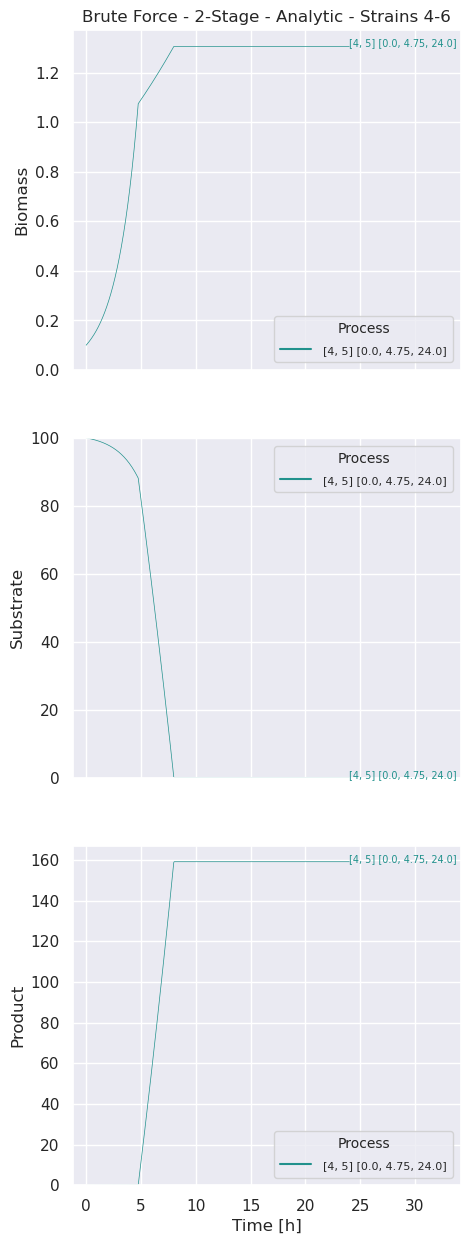

In [6]:
%%time
t_start = 0
t_end = 24
min_duration = 1
n_stages = 2
den = 4
combis = list(itertools.product([3, 4, 5], [3, 4, 5]))  

BruteForceAnalytic_2Stage_EcolacATPase = msp.do_brute_force_ana(combis, models_analytic, n_stages, t_start, t_end, min_duration, s, den)
display(BruteForceAnalytic_2Stage_EcolacATPase)
#msp.do_save(BruteForceAnalytic_2Stage_EcolacATPase, './Results/Computer_Stg2_ana_brf_4to6_den4.pickle')

BruteForceAnalytic_2Stage_EcolacATPase_best = (BruteForceAnalytic_2Stage_EcolacATPase.sort_values(["Vol_P"], ascending=[False]).dropna(axis=0).drop_duplicates(subset="Models", keep="first")[:1])
display(BruteForceAnalytic_2Stage_EcolacATPase_best)
msp.do_custom_plot(df=BruteForceAnalytic_2Stage_EcolacATPase_best, models_num=models_numeric, s=s, title="Brute Force - 2-Stage - Analytic - Strains 4-6")

## Two-Stage fermentation  - Numeric
(could be seen as strain comparison)

With density = 4 in paper denoted as ($t_{step}$=0.25h)

,Index,Times,Models,End_T,End_X,End_S,End_P,finished,Vol_P,Y_SubInput,Y_SubUsed
0,1,"(0.0, 1.0, 24.0)","[1, 1]",8.15,6.92,0.00,1.57,2,0.19,0.02,0.02
1,2,"(0.0, 1.25, 24.0)","[1, 1]",8.15,6.92,0.00,1.57,2,0.19,0.02,0.02
2,3,"(0.0, 1.5, 24.0)","[1, 1]",8.15,6.92,0.00,1.57,2,0.19,0.02,0.02
3,4,"(0.0, 1.75, 24.0)","[1, 1]",8.15,6.92,0.00,1.57,2,0.19,0.02,0.02
4,5,"(0.0, 2.0, 24.0)","[1, 1]",8.15,6.92,0.00,1.57,2,0.19,0.02,0.02
...,...,...,...,...,...,...,...,...,...,...,...
547,548,"(0.0, 22.0, 24.0)","[3, 3]",24.00,0.10,97.94,3.41,inf,0.14,0.03,1.65
548,549,"(0.0, 22.25, 24.0)","[3, 3]",24.00,0.10,97.94,3.41,inf,0.14,0.03,1.65
549,550,"(0.0, 22.5, 24.0)","[3, 3]",24.00,0.10,97.94,3.41,inf,0.14,0.03,1.65
550,551,"(0.0, 22.75, 24.0)","[3, 3]",24.00,0.10,97.94,3.41,inf,0.14,0.03,1.65


,Index,Times,Models,End_T,End_X,End_S,End_P,finished,Vol_P,Y_SubInput,Y_SubUsed
44,45,"(0.0, 4.5, 24.0)","[1, 2]",8.44,1.73,0.0,139.83,2,16.56,1.4,1.4


CPU times: user 2min 9s, sys: 177 ms, total: 2min 9s
Wall time: 2min 8s


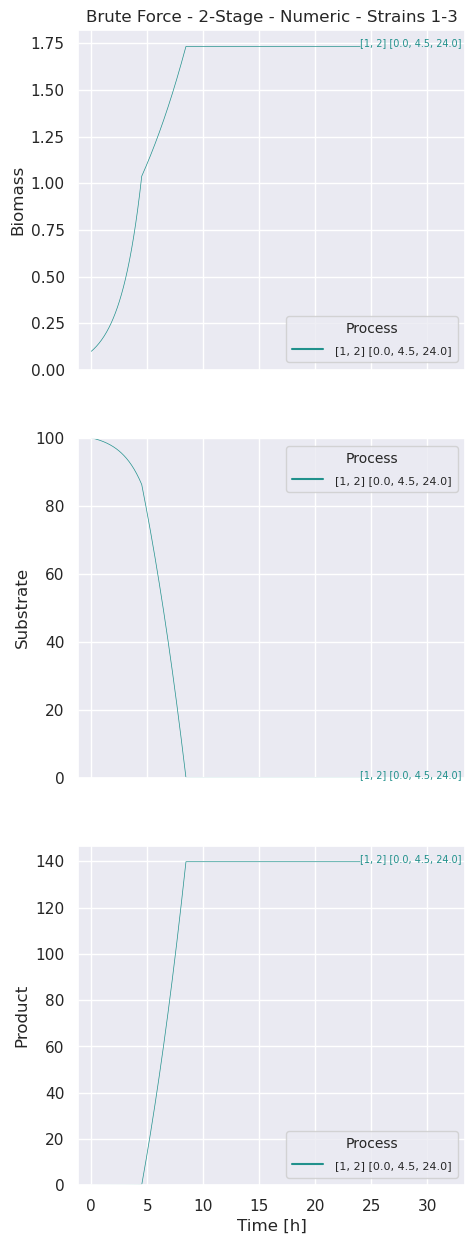

In [7]:
%%time
t_start = 0
t_end = 24
min_duration = 1
n_stages = 2
den = 4
combis = list(itertools.product([0, 1, 2], [0, 1, 2]))  

BruteForceNumeric_2Stage_Ecolac = msp.do_brute_force_num(combis, models_numeric, n_stages, t_start, t_end, min_duration, s, density=den)
display(BruteForceNumeric_2Stage_Ecolac)
#msp.do_save(BruteForceNumeric_2Stage_Ecolac, './Results/Computer_Stg2_num_brf_1to3_den4.pickle')

BruteForceNumeric_2Stage_Ecolac_best = (BruteForceNumeric_2Stage_Ecolac.sort_values(["Vol_P"], ascending=[False]).dropna(axis=0).drop_duplicates(subset="Models", keep="first")[:1])
display(BruteForceNumeric_2Stage_Ecolac_best)
msp.do_custom_plot(df=BruteForceNumeric_2Stage_Ecolac_best, models_num=models_numeric, s=s, title="Brute Force - 2-Stage - Numeric - Strains 1-3")

,Index,Times,Models,End_T,End_X,End_S,End_P,finished,Vol_P,Y_SubInput,Y_SubUsed
0,1,"(0.0, 1.0, 24.0)","[4, 4]",8.84,8.32,0.00,1.32,2,0.15,0.01,0.01
1,2,"(0.0, 1.25, 24.0)","[4, 4]",8.84,8.32,0.00,1.32,2,0.15,0.01,0.01
2,3,"(0.0, 1.5, 24.0)","[4, 4]",8.84,8.32,0.00,1.32,2,0.15,0.01,0.01
3,4,"(0.0, 1.75, 24.0)","[4, 4]",8.84,8.32,0.00,1.32,2,0.15,0.01,0.01
4,5,"(0.0, 2.0, 24.0)","[4, 4]",8.84,8.32,0.00,1.32,2,0.15,0.01,0.01
...,...,...,...,...,...,...,...,...,...,...,...
610,611,"(0.0, 22.0, 24.0)","[6, 6]",24.00,0.10,77.51,42.26,inf,1.76,0.42,1.88
611,612,"(0.0, 22.25, 24.0)","[6, 6]",24.00,0.10,77.51,42.26,inf,1.76,0.42,1.88
612,613,"(0.0, 22.5, 24.0)","[6, 6]",24.00,0.10,77.51,42.26,inf,1.76,0.42,1.88
613,614,"(0.0, 22.75, 24.0)","[6, 6]",24.00,0.10,77.51,42.26,inf,1.76,0.42,1.88


,Index,Times,Models,End_T,End_X,End_S,End_P,finished,Vol_P,Y_SubInput,Y_SubUsed
48,49,"(0.0, 4.75, 24.0)","[4, 5]",8.0,1.31,0.0,159.2,2,19.9,1.59,1.59


CPU times: user 2min 51s, sys: 161 ms, total: 2min 51s
Wall time: 2min 51s


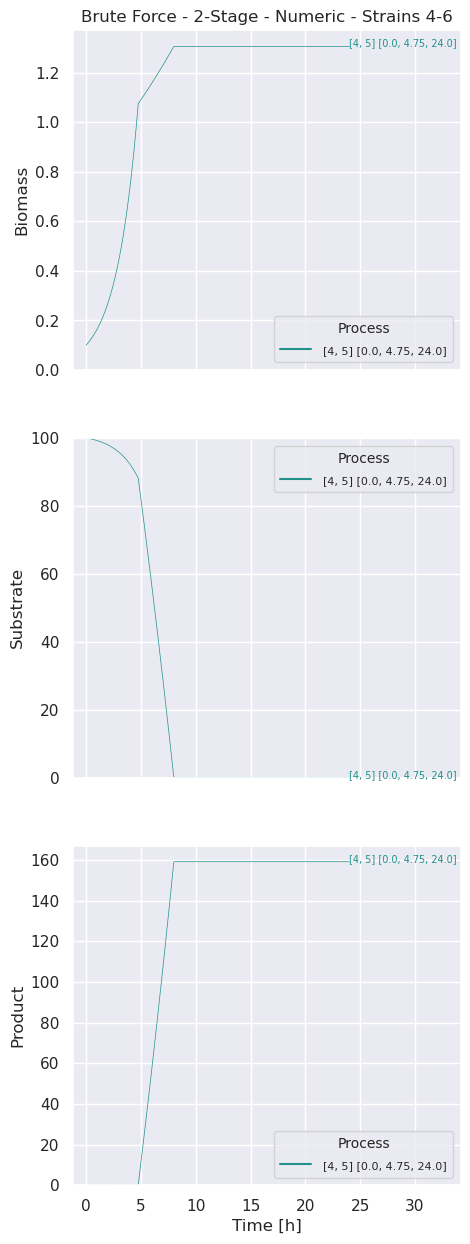

In [8]:
%%time
t_start = 0
t_end = 24
min_duration = 1
n_stages = 2
den = 4
combis = list(itertools.product([3, 4, 5], [3, 4, 5]))  

BruteForceNumeric_2Stage_EcolacATPase = msp.do_brute_force_num(combis, models_numeric, n_stages, t_start, t_end, min_duration, s, density=den)
display(BruteForceNumeric_2Stage_EcolacATPase)
#msp.do_save(BruteForceNumeric_2Stage_EcolacATPase, './Results/Computer_Stg2_num_brf_4to6_den4.pickle')

BruteForceNumeric_2Stage_EcolacATPase_best = (BruteForceNumeric_2Stage_EcolacATPase.sort_values(["Vol_P"], ascending=[False]).dropna(axis=0).drop_duplicates(subset="Models", keep="first")[:1])
display(BruteForceNumeric_2Stage_EcolacATPase_best)
msp.do_custom_plot(df=BruteForceNumeric_2Stage_EcolacATPase_best, models_num=models_numeric, s=s, title="Brute Force - 2-Stage - Numeric - Strains 4-6")

## Two-Stage fermentation (all modules)  - Analytic

### With density = 4 in paper denoted as ($t_{step}$=0.25h)

,Index,Times,Models,End_T,End_X,End_S,End_P,finished,Vol_P,Y_SubInput,Y_SubUsed
0,1,"(0.0, 1.0, 24.0)","[1, 1]",8.15,6.92,-0.00,1.57,2,0.19,0.02,0.02
1,2,"(0.0, 1.25, 24.0)","[1, 1]",8.15,6.92,0.00,1.57,2,0.19,0.02,0.02
2,3,"(0.0, 1.5, 24.0)","[1, 1]",8.15,6.92,0.00,1.57,2,0.19,0.02,0.02
3,4,"(0.0, 1.75, 24.0)","[1, 1]",8.15,6.92,0.00,1.57,2,0.19,0.02,0.02
4,5,"(0.0, 2.0, 24.0)","[1, 1]",8.15,6.92,0.00,1.57,2,0.19,0.02,0.02
...,...,...,...,...,...,...,...,...,...,...,...
2329,2330,"(0.0, 22.0, 24.0)","[6, 6]",24.00,0.10,77.51,42.26,inf,1.76,0.42,1.88
2330,2331,"(0.0, 22.25, 24.0)","[6, 6]",24.00,0.10,77.51,42.26,inf,1.76,0.42,1.88
2331,2332,"(0.0, 22.5, 24.0)","[6, 6]",24.00,0.10,77.51,42.26,inf,1.76,0.42,1.88
2332,2333,"(0.0, 22.75, 24.0)","[6, 6]",24.00,0.10,77.51,42.26,inf,1.76,0.42,1.88


,Index,Times,Models,End_T,End_X,End_S,End_P,finished,Vol_P,Y_SubInput,Y_SubUsed
134,135,"(0.0, 4.5, 24.0)","[1, 5]",7.79,1.26,0.0,155.86,2,20.01,1.56,1.56


CPU times: user 1.19 s, sys: 164 ms, total: 1.35 s
Wall time: 1.13 s


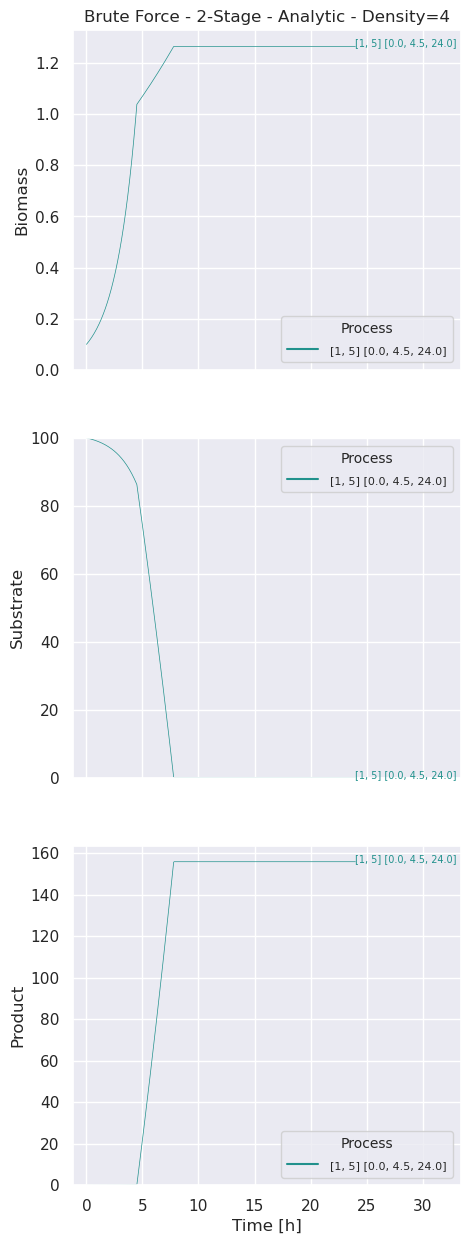

In [10]:
%%time
t_start = 0
t_end = 24
min_duration = 1
n_stages = 2
density = 4
combis = list(itertools.product([0, 1, 2, 3, 4, 5], [0, 1, 2, 3, 4, 5]))  # all combinations for 2-stage: [(0, 0), (0, 1), ... , (5, 5)]

BruteForceAnalytic_2Stage_den4 = msp.do_brute_force_ana(combis, models_analytic, n_stages, t_start, t_end, min_duration, s, density)
display(BruteForceAnalytic_2Stage_den4)

BruteForceAnalytic_2Stage_den4_best = (BruteForceAnalytic_2Stage_den4.sort_values(["Vol_P"], ascending=[False]).dropna(axis=0).drop_duplicates(subset="Models", keep="first")[:1])
display(BruteForceAnalytic_2Stage_den4_best)
msp.do_custom_plot(df=BruteForceAnalytic_2Stage_den4_best, models_num=models_numeric, s=s, title="Brute Force - 2-Stage - Analytic - Density=4")

## Two-Stage fermentation (all modules) - Numeric 

### With density = 4 in paper denoted as ($t_{step}$=0.25h)

,Index,Times,Models,End_T,End_X,End_S,End_P,finished,Vol_P,Y_SubInput,Y_SubUsed
0,1,"(0.0, 1.0, 24.0)","[1, 1]",8.15,6.92,0.00,1.57,2,0.19,0.02,0.02
1,2,"(0.0, 1.25, 24.0)","[1, 1]",8.15,6.92,0.00,1.57,2,0.19,0.02,0.02
2,3,"(0.0, 1.5, 24.0)","[1, 1]",8.15,6.92,0.00,1.57,2,0.19,0.02,0.02
3,4,"(0.0, 1.75, 24.0)","[1, 1]",8.15,6.92,0.00,1.57,2,0.19,0.02,0.02
4,5,"(0.0, 2.0, 24.0)","[1, 1]",8.15,6.92,0.00,1.57,2,0.19,0.02,0.02
...,...,...,...,...,...,...,...,...,...,...,...
2329,2330,"(0.0, 22.0, 24.0)","[6, 6]",24.00,0.10,77.51,42.26,inf,1.76,0.42,1.88
2330,2331,"(0.0, 22.25, 24.0)","[6, 6]",24.00,0.10,77.51,42.26,inf,1.76,0.42,1.88
2331,2332,"(0.0, 22.5, 24.0)","[6, 6]",24.00,0.10,77.51,42.26,inf,1.76,0.42,1.88
2332,2333,"(0.0, 22.75, 24.0)","[6, 6]",24.00,0.10,77.51,42.26,inf,1.76,0.42,1.88


,Index,Times,Models,End_T,End_X,End_S,End_P,finished,Vol_P,Y_SubInput,Y_SubUsed
134,135,"(0.0, 4.5, 24.0)","[1, 5]",7.79,1.26,0.0,155.85,2,20.01,1.56,1.56


CPU times: user 10min 3s, sys: 156 ms, total: 10min 3s
Wall time: 10min 3s


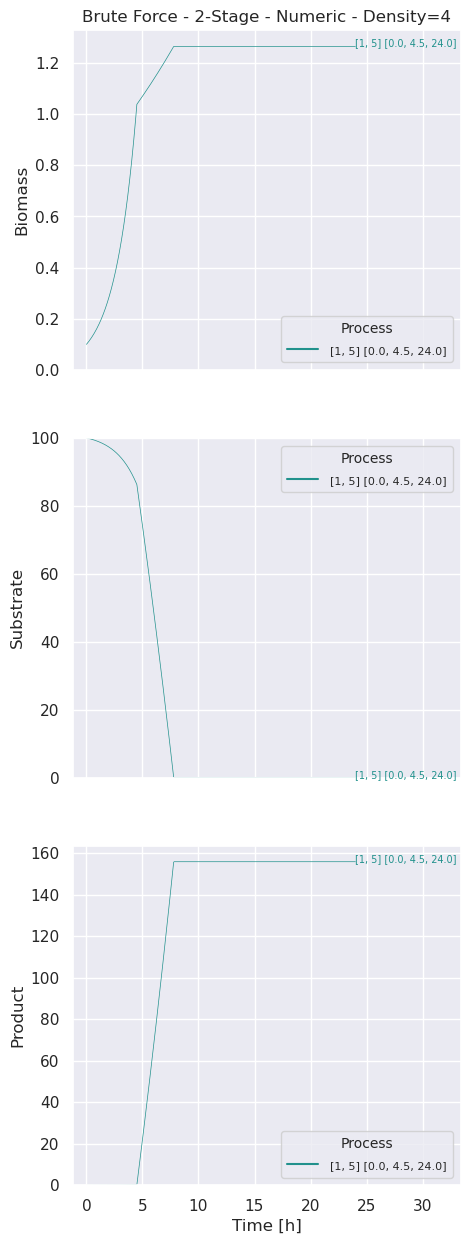

In [12]:
%%time
t_start = 0
t_end = 24
min_duration = 1
n_stages = 2
den = 4
combis = list(itertools.product([0, 1, 2, 3, 4, 5], [0, 1, 2, 3, 4, 5]))  # all combinations for 2-stage: [(0, 0), (0, 1), ... , (5, 5)]

BruteForceNumeric_2Stage_den4 = msp.do_brute_force_num(combis, models_numeric, n_stages, t_start, t_end, min_duration, s, density=den)
display(BruteForceNumeric_2Stage_den4)

BruteForceNumeric_2Stage_den4_best = (BruteForceNumeric_2Stage_den4.sort_values(["Vol_P"], ascending=[False]).dropna(axis=0).drop_duplicates(subset="Models", keep="first")[:1])
display(BruteForceNumeric_2Stage_den4_best)
msp.do_custom_plot(df=BruteForceNumeric_2Stage_den4_best, models_num=models_numeric, s=s, title="Brute Force - 2-Stage - Numeric - Density=4")

## Three-Stage fermentation  - Analytic
(could be seen as strain comparison)

### With density = 4 in paper denoted as ($t_{step}$=0.25h)

,Index,Times,Models,End_T,End_X,End_S,End_P,finished,Vol_P,Y_SubInput,Y_SubUsed
0,1,"(0.0, 1.0, 2.0, 24.0)","[1, 1, 1]",8.15,6.92,-0.00,1.57,3,0.19,0.02,0.02
1,2,"(0.0, 1.0, 2.25, 24.0)","[1, 1, 1]",8.15,6.92,0.00,1.57,3,0.19,0.02,0.02
2,3,"(0.0, 1.0, 2.5, 24.0)","[1, 1, 1]",8.15,6.92,0.00,1.57,3,0.19,0.02,0.02
3,4,"(0.0, 1.0, 2.75, 24.0)","[1, 1, 1]",8.15,6.92,0.00,1.57,3,0.19,0.02,0.02
4,5,"(0.0, 1.0, 3.0, 24.0)","[1, 1, 1]",8.15,6.92,-0.00,1.57,3,0.19,0.02,0.02
...,...,...,...,...,...,...,...,...,...,...,...
55312,55313,"(0.0, 21.5, 22.75, 24.0)","[3, 3, 3]",24.00,0.10,97.94,3.41,inf,0.14,0.03,1.65
55313,55314,"(0.0, 21.5, 23.0, 24.0)","[3, 3, 3]",24.00,0.10,97.94,3.41,inf,0.14,0.03,1.65
55314,55315,"(0.0, 21.75, 22.75, 24.0)","[3, 3, 3]",24.00,0.10,97.94,3.41,inf,0.14,0.03,1.65
55315,55316,"(0.0, 21.75, 23.0, 24.0)","[3, 3, 3]",24.00,0.10,97.94,3.41,inf,0.14,0.03,1.65


,Index,Times,Models,End_T,End_X,End_S,End_P,finished,Vol_P,Y_SubInput,Y_SubUsed
500,501,"(0.0, 2.5, 4.5, 24.0)","[1, 1, 2]",8.44,1.73,0.0,139.84,3,16.56,1.4,1.4


CPU times: user 8.85 s, sys: 164 ms, total: 9.01 s
Wall time: 8.79 s


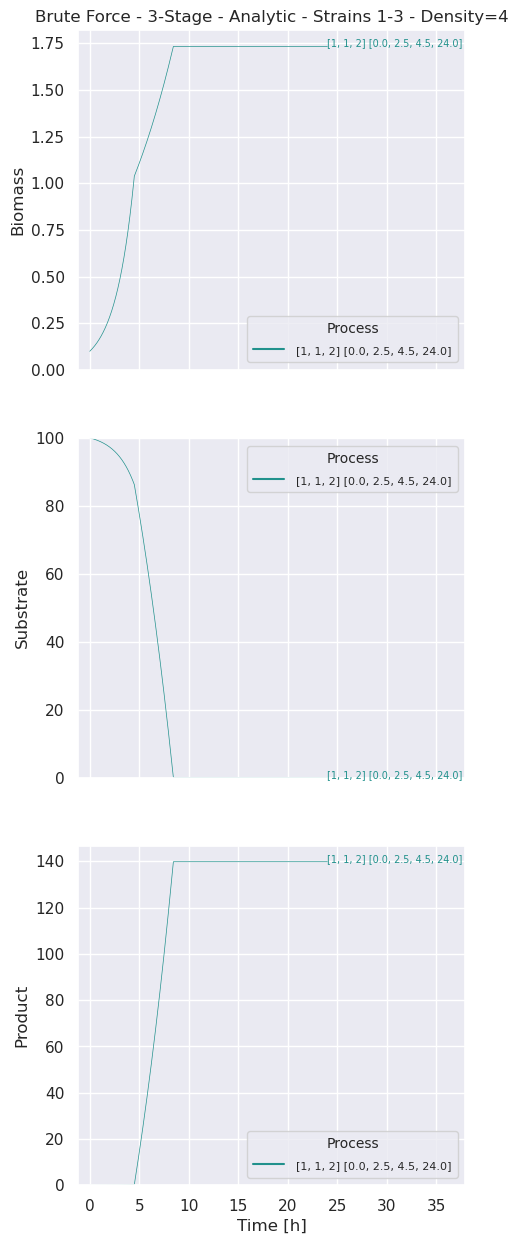

In [15]:
%%time
t_start = 0
t_end = 24
min_duration = 1
n_stages = 3
den = 4
combis = list(itertools.product([0, 1, 2], [0, 1, 2], [0, 1, 2]))  # all combinations for 2-stage: [(0, 0), (0, 1), ... , (5, 5)]

BruteForceAnalytic_3Stage_den4_Ecolac = msp.do_brute_force_ana(combis, models_analytic, n_stages, t_start, t_end, min_duration, s, density=den)
display(BruteForceAnalytic_3Stage_den4_Ecolac)

BruteForceAnalytic_3Stage_den4_Ecolac_best = (BruteForceAnalytic_3Stage_den4_Ecolac.sort_values(["Vol_P"], ascending=[False]).dropna(axis=0).drop_duplicates(subset="Models", keep="first")[:1])
display(BruteForceAnalytic_3Stage_den4_Ecolac_best)
msp.do_custom_plot(df=BruteForceAnalytic_3Stage_den4_Ecolac_best, models_num=models_numeric, s=s, title="Brute Force - 3-Stage - Analytic - Strains 1-3 - Density=4")

,Index,Times,Models,End_T,End_X,End_S,End_P,finished,Vol_P,Y_SubInput,Y_SubUsed
0,1,"(0.0, 1.0, 2.0, 24.0)","[4, 4, 4]",8.84,8.32,0.00,1.32,3,0.15,0.01,0.01
1,2,"(0.0, 1.0, 2.25, 24.0)","[4, 4, 4]",8.84,8.32,0.00,1.32,3,0.15,0.01,0.01
2,3,"(0.0, 1.0, 2.5, 24.0)","[4, 4, 4]",8.84,8.32,0.00,1.32,3,0.15,0.01,0.01
3,4,"(0.0, 1.0, 2.75, 24.0)","[4, 4, 4]",8.84,8.32,0.00,1.32,3,0.15,0.01,0.01
4,5,"(0.0, 1.0, 3.0, 24.0)","[4, 4, 4]",8.84,8.32,0.00,1.32,3,0.15,0.01,0.01
...,...,...,...,...,...,...,...,...,...,...,...
61246,61247,"(0.0, 21.5, 22.75, 24.0)","[6, 6, 6]",24.00,0.10,77.51,42.26,inf,1.76,0.42,1.88
61247,61248,"(0.0, 21.5, 23.0, 24.0)","[6, 6, 6]",24.00,0.10,77.51,42.26,inf,1.76,0.42,1.88
61248,61249,"(0.0, 21.75, 22.75, 24.0)","[6, 6, 6]",24.00,0.10,77.51,42.26,inf,1.76,0.42,1.88
61249,61250,"(0.0, 21.75, 23.0, 24.0)","[6, 6, 6]",24.00,0.10,77.51,42.26,inf,1.76,0.42,1.88


,Index,Times,Models,End_T,End_X,End_S,End_P,finished,Vol_P,Y_SubInput,Y_SubUsed
450,451,"(0.0, 1.0, 4.75, 24.0)","[4, 4, 5]",8.0,1.31,0.0,159.21,3,19.91,1.59,1.59


CPU times: user 9.64 s, sys: 176 ms, total: 9.81 s
Wall time: 9.59 s


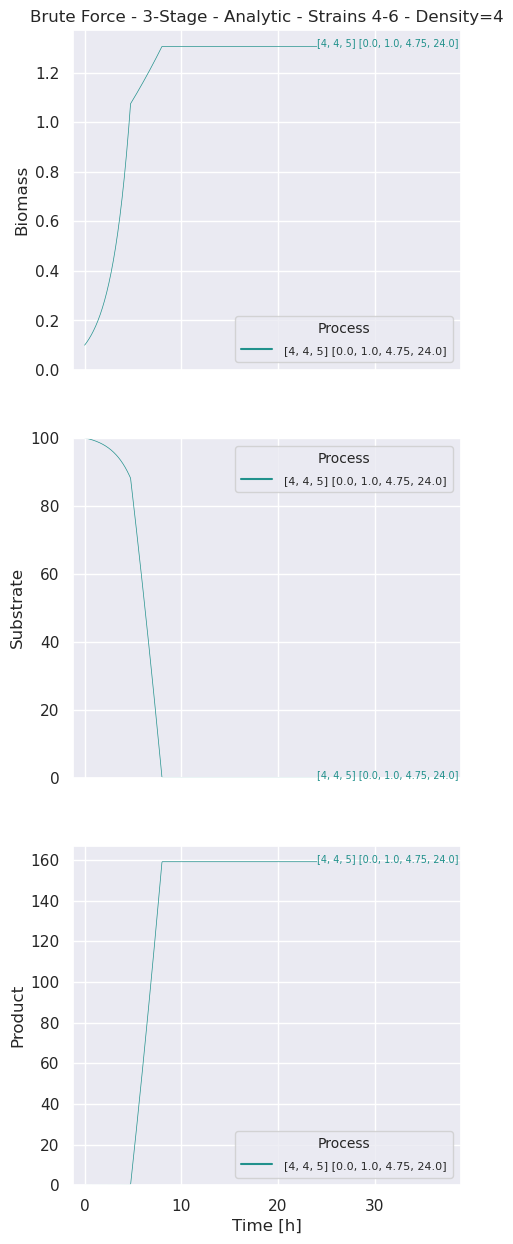

In [16]:
%%time
t_start = 0
t_end = 24
min_duration = 1
n_stages = 3
den = 4
combis = list(itertools.product([3, 4, 5], [3, 4, 5], [3, 4, 5]))  # all combinations for 2-stage: [(0, 0), (0, 1), ... , (5, 5)]

BruteForceAnalytic_3Stage_den4_EcolacATPase = msp.do_brute_force_ana(combis, models_analytic, n_stages, t_start, t_end, min_duration, s, density=den)
display(BruteForceAnalytic_3Stage_den4_EcolacATPase)

BruteForceAnalytic_3Stage_den4_EcolacATPase_best = (BruteForceAnalytic_3Stage_den4_EcolacATPase.sort_values(["Vol_P"], ascending=[False]).dropna(axis=0).drop_duplicates(subset="Models", keep="first")[:1])
display(BruteForceAnalytic_3Stage_den4_EcolacATPase_best)

msp.do_custom_plot(df=BruteForceAnalytic_3Stage_den4_EcolacATPase_best, models_num=models_numeric, s=s, title="Brute Force - 3-Stage - Analytic - Strains 4-6 - Density=4")

## Three-Stage fermentation  - Numeric
(could be seen as strain comparison)

### With density = 4 in paper denoted as ($t_{step}$=0.25h)

,Index,Times,Models,End_T,End_X,End_S,End_P,finished,Vol_P,Y_SubInput,Y_SubUsed
0,1,"(0.0, 1.0, 2.0, 24.0)","[1, 1, 1]",8.15,6.92,0.00,1.57,3,0.19,0.02,0.02
1,2,"(0.0, 1.0, 2.25, 24.0)","[1, 1, 1]",8.15,6.92,0.00,1.57,3,0.19,0.02,0.02
2,3,"(0.0, 1.0, 2.5, 24.0)","[1, 1, 1]",8.15,6.92,0.00,1.57,3,0.19,0.02,0.02
3,4,"(0.0, 1.0, 2.75, 24.0)","[1, 1, 1]",8.15,6.92,0.00,1.57,3,0.19,0.02,0.02
4,5,"(0.0, 1.0, 3.0, 24.0)","[1, 1, 1]",8.15,6.92,0.00,1.57,3,0.19,0.02,0.02
...,...,...,...,...,...,...,...,...,...,...,...
55312,55313,"(0.0, 21.5, 22.75, 24.0)","[3, 3, 3]",24.00,0.10,97.94,3.41,inf,0.14,0.03,1.65
55313,55314,"(0.0, 21.5, 23.0, 24.0)","[3, 3, 3]",24.00,0.10,97.94,3.41,inf,0.14,0.03,1.65
55314,55315,"(0.0, 21.75, 22.75, 24.0)","[3, 3, 3]",24.00,0.10,97.94,3.41,inf,0.14,0.03,1.65
55315,55316,"(0.0, 21.75, 23.0, 24.0)","[3, 3, 3]",24.00,0.10,97.94,3.41,inf,0.14,0.03,1.65


,Index,Times,Models,End_T,End_X,End_S,End_P,finished,Vol_P,Y_SubInput,Y_SubUsed
500,501,"(0.0, 2.5, 4.5, 24.0)","[1, 1, 2]",8.44,1.73,0.0,139.83,3,16.56,1.4,1.4


CPU times: user 3h 32min 43s, sys: 228 ms, total: 3h 32min 43s
Wall time: 3h 32min 43s


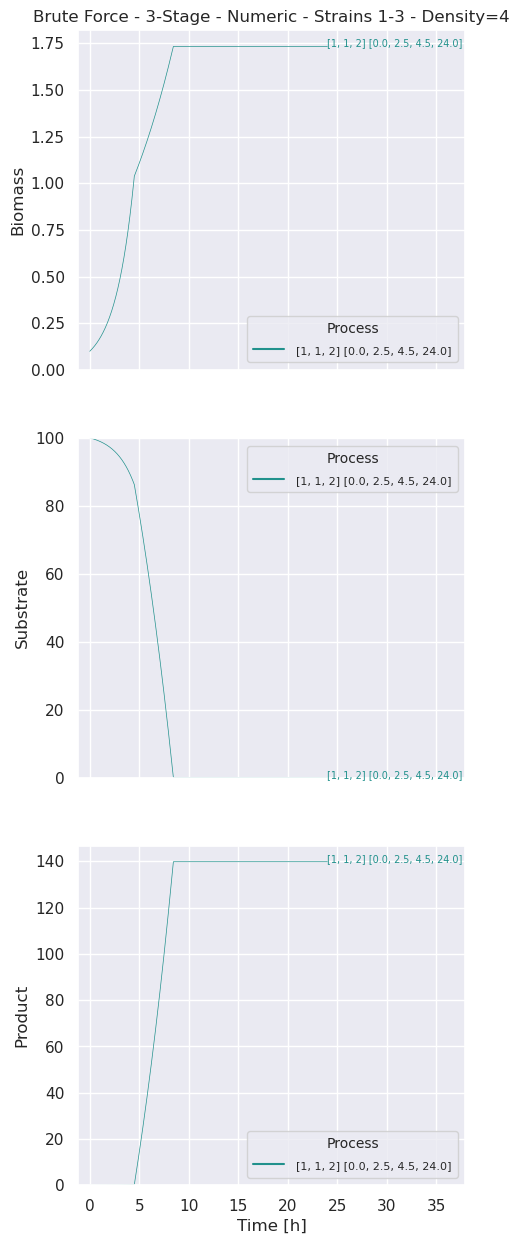

In [19]:
%%time
t_start = 0
t_end = 24
min_duration = 1
n_stages = 3
den = 4
combis = list(itertools.product([0, 1, 2], [0, 1, 2], [0, 1, 2]))  # all combinations for 2-stage: [(0, 0), (0, 1), ... , (5, 5)]

BruteForceNumeric_3Stage_den4_Ecolac = msp.do_brute_force_num(combis, models_numeric, n_stages, t_start, t_end, min_duration, s, density= den)
display(BruteForceNumeric_3Stage_den4_Ecolac)

BruteForceNumeric_3Stage_den4_Ecolac_best = (BruteForceNumeric_3Stage_den4_Ecolac.sort_values(["Vol_P"], ascending=[False]).dropna(axis=0).drop_duplicates(subset="Models", keep="first")[:1])
display(BruteForceNumeric_3Stage_den4_Ecolac_best)
msp.do_custom_plot(df=BruteForceNumeric_3Stage_den4_Ecolac_best, models_num=models_numeric, s=s, title="Brute Force - 3-Stage - Numeric - Strains 1-3 - Density=4")

,Index,Times,Models,End_T,End_X,End_S,End_P,finished,Vol_P,Y_SubInput,Y_SubUsed
0,1,"(0.0, 1.0, 2.0, 24.0)","[4, 4, 4]",8.84,8.32,0.00,1.32,3,0.15,0.01,0.01
1,2,"(0.0, 1.0, 2.25, 24.0)","[4, 4, 4]",8.84,8.32,0.00,1.32,3,0.15,0.01,0.01
2,3,"(0.0, 1.0, 2.5, 24.0)","[4, 4, 4]",8.84,8.32,0.00,1.32,3,0.15,0.01,0.01
3,4,"(0.0, 1.0, 2.75, 24.0)","[4, 4, 4]",8.84,8.32,0.00,1.32,3,0.15,0.01,0.01
4,5,"(0.0, 1.0, 3.0, 24.0)","[4, 4, 4]",8.84,8.32,0.00,1.32,3,0.15,0.01,0.01
...,...,...,...,...,...,...,...,...,...,...,...
61246,61247,"(0.0, 21.5, 22.75, 24.0)","[6, 6, 6]",24.00,0.10,77.51,42.26,inf,1.76,0.42,1.88
61247,61248,"(0.0, 21.5, 23.0, 24.0)","[6, 6, 6]",24.00,0.10,77.51,42.26,inf,1.76,0.42,1.88
61248,61249,"(0.0, 21.75, 22.75, 24.0)","[6, 6, 6]",24.00,0.10,77.51,42.26,inf,1.76,0.42,1.88
61249,61250,"(0.0, 21.75, 23.0, 24.0)","[6, 6, 6]",24.00,0.10,77.51,42.26,inf,1.76,0.42,1.88


,Index,Times,Models,End_T,End_X,End_S,End_P,finished,Vol_P,Y_SubInput,Y_SubUsed
2368,2369,"(0.0, 5.0, 6.75, 24.0)","[4, 5, 5]",7.85,1.45,0.0,156.09,3,19.9,1.56,1.56


CPU times: user 4h 30min 3s, sys: 176 ms, total: 4h 30min 4s
Wall time: 4h 30min 4s


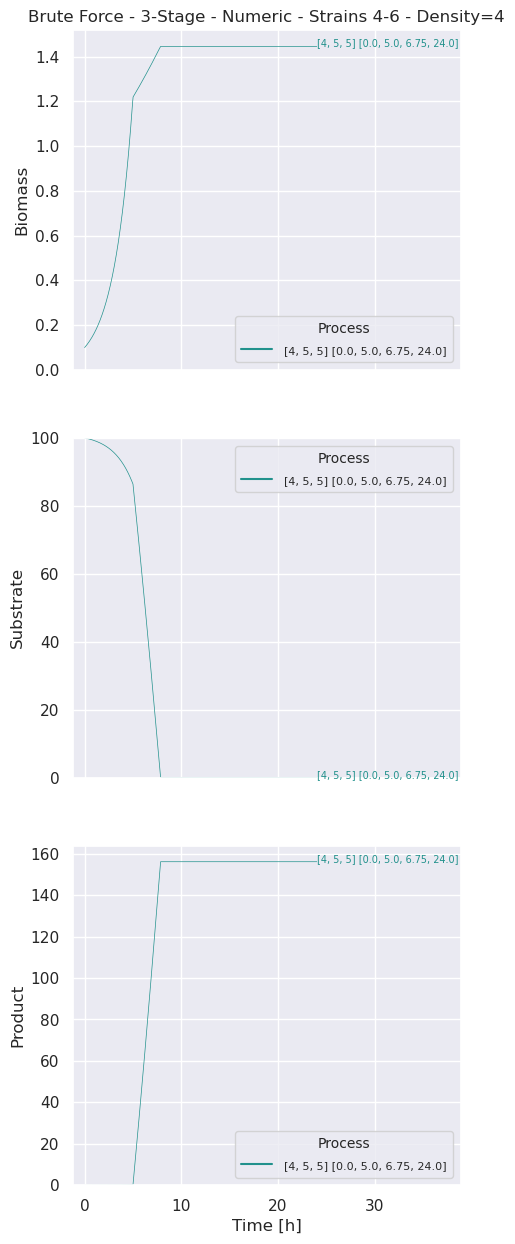

In [20]:
%%time
t_start = 0
t_end = 24
min_duration = 1
n_stages = 3
den = 4
combis = list(itertools.product([3, 4, 5], [3, 4, 5], [3, 4, 5]))  # all combinations for 2-stage: [(0, 0), (0, 1), ... , (5, 5)]

BruteForceNumeric_3Stage_den4_EcolacATPase = msp.do_brute_force_num(combis, models_numeric, n_stages, t_start, t_end, min_duration, s, density=den)
display(BruteForceNumeric_3Stage_den4_EcolacATPase)

BruteForceNumeric_3Stage_den4_EcolacATPase_best = (BruteForceNumeric_3Stage_den4_EcolacATPase.sort_values(["Vol_P"], ascending=[False]).dropna(axis=0).drop_duplicates(subset="Models", keep="first")[:1])
display(BruteForceNumeric_3Stage_den4_EcolacATPase_best)
msp.do_custom_plot(df=BruteForceNumeric_3Stage_den4_EcolacATPase_best, models_num=models_numeric, s=s, title="Brute Force - 3-Stage - Numeric - Strains 4-6 - Density=4")

## Three-Stage fermentation (all modules)  - Analytic

### With density = 4 in paper denoted as ($t_{step}$=0.25h)

,Index,Times,Models,End_T,End_X,End_S,End_P,finished,Vol_P,Y_SubInput,Y_SubUsed
0,1,"(0.0, 1.0, 2.0, 24.0)","[1, 1, 1]",8.15,6.92,-0.00,1.57,3,0.193,0.02,0.02
1,2,"(0.0, 1.0, 2.25, 24.0)","[1, 1, 1]",8.15,6.92,0.00,1.57,3,0.193,0.02,0.02
2,3,"(0.0, 1.0, 2.5, 24.0)","[1, 1, 1]",8.15,6.92,0.00,1.57,3,0.193,0.02,0.02
3,4,"(0.0, 1.0, 2.75, 24.0)","[1, 1, 1]",8.15,6.92,0.00,1.57,3,0.193,0.02,0.02
4,5,"(0.0, 1.0, 3.0, 24.0)","[1, 1, 1]",8.15,6.92,-0.00,1.57,3,0.193,0.02,0.02
...,...,...,...,...,...,...,...,...,...,...,...
464329,464330,"(0.0, 21.5, 22.75, 24.0)","[6, 6, 6]",24.00,0.10,77.51,42.26,inf,1.761,0.42,1.88
464330,464331,"(0.0, 21.5, 23.0, 24.0)","[6, 6, 6]",24.00,0.10,77.51,42.26,inf,1.761,0.42,1.88
464331,464332,"(0.0, 21.75, 22.75, 24.0)","[6, 6, 6]",24.00,0.10,77.51,42.26,inf,1.761,0.42,1.88
464332,464333,"(0.0, 21.75, 23.0, 24.0)","[6, 6, 6]",24.00,0.10,77.51,42.26,inf,1.761,0.42,1.88


,Index,Times,Models,End_T,End_X,End_S,End_P,finished,Vol_P,Y_SubInput,Y_SubUsed
18449,18450,"(0.0, 3.25, 4.75, 24.0)","[1, 4, 5]",7.75,1.37,-0.0,155.68,3,20.091,1.56,1.56


CPU times: user 1min 5s, sys: 268 ms, total: 1min 5s
Wall time: 1min 5s


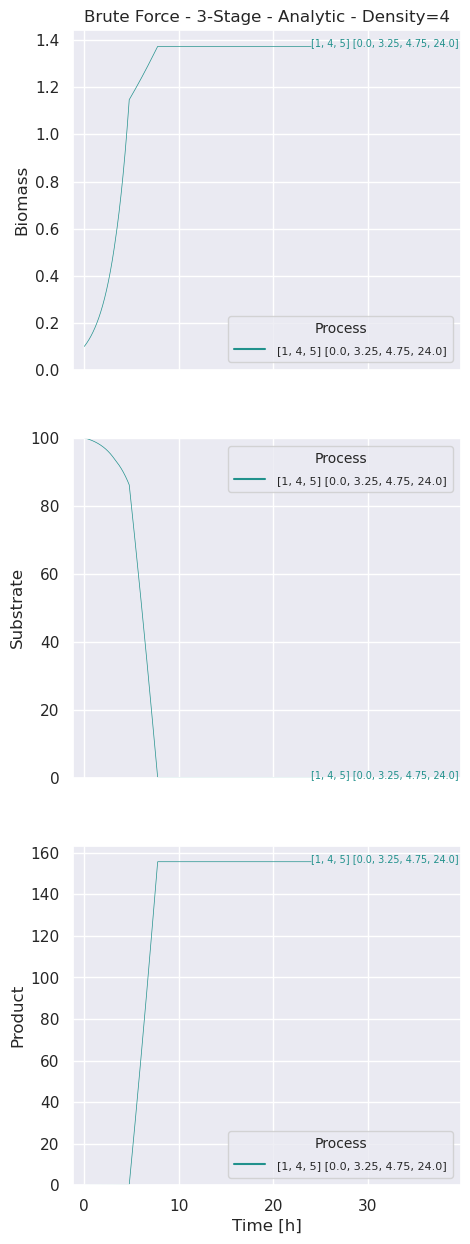

In [44]:
%%time
t_start = 0
t_end = 24
min_duration = 1
n_stages = 3
den=4
combis = list(itertools.product([0, 1, 2, 3, 4, 5], [0, 1, 2, 3, 4, 5], [0, 1, 2, 3, 4, 5]))  # all combinations for 2-stage: [(0, 0), (0, 1), ... , (5, 5)]

BruteForceAnalytic_3Stage_den4 = msp.do_brute_force_ana(combis, models_analytic, n_stages, t_start, t_end, min_duration, s, density=den)
display(BruteForceAnalytic_3Stage_den4)

BruteForceAnalytic_3Stage_den4_best = (BruteForceAnalytic_3Stage_den4.sort_values(["Vol_P"], ascending=[False]).dropna(axis=0).drop_duplicates(subset="Models", keep="first")[:1])
display(BruteForceAnalytic_3Stage_den4_best)
msp.do_custom_plot(df=BruteForceAnalytic_3Stage_den4_best, models_num=models_numeric, s=s, title="Brute Force - 3-Stage - Analytic - Density=4")

## Three-Stage fermentation (all modules)  - Numeric

### With density = 4 in paper denoted as ($t_{step}$=0.25h)

,Index,Times,Models,End_T,End_X,End_S,End_P,finished,Vol_P,Y_SubInput,Y_SubUsed
0,1,"(0.0, 1.0, 2.0, 24.0)","[1, 1, 1]",8.15,6.92,0.00,1.57,3,0.193,0.02,0.02
1,2,"(0.0, 1.0, 2.25, 24.0)","[1, 1, 1]",8.15,6.92,0.00,1.57,3,0.193,0.02,0.02
2,3,"(0.0, 1.0, 2.5, 24.0)","[1, 1, 1]",8.15,6.92,0.00,1.57,3,0.193,0.02,0.02
3,4,"(0.0, 1.0, 2.75, 24.0)","[1, 1, 1]",8.15,6.92,0.00,1.57,3,0.193,0.02,0.02
4,5,"(0.0, 1.0, 3.0, 24.0)","[1, 1, 1]",8.15,6.92,0.00,1.57,3,0.193,0.02,0.02
...,...,...,...,...,...,...,...,...,...,...,...
464329,464330,"(0.0, 21.5, 22.75, 24.0)","[6, 6, 6]",24.00,0.10,77.51,42.26,inf,1.761,0.42,1.88
464330,464331,"(0.0, 21.5, 23.0, 24.0)","[6, 6, 6]",24.00,0.10,77.51,42.26,inf,1.761,0.42,1.88
464331,464332,"(0.0, 21.75, 22.75, 24.0)","[6, 6, 6]",24.00,0.10,77.51,42.26,inf,1.761,0.42,1.88
464332,464333,"(0.0, 21.75, 23.0, 24.0)","[6, 6, 6]",24.00,0.10,77.51,42.26,inf,1.761,0.42,1.88


,Index,Times,Models,End_T,End_X,End_S,End_P,finished,Vol_P,Y_SubInput,Y_SubUsed
18449,18450,"(0.0, 3.25, 4.75, 24.0)","[1, 4, 5]",7.75,1.37,0.0,155.67,3,20.091,1.56,1.56


CPU times: user 1d 7h 3min 21s, sys: 504 ms, total: 1d 7h 3min 22s
Wall time: 1d 7h 3min 24s


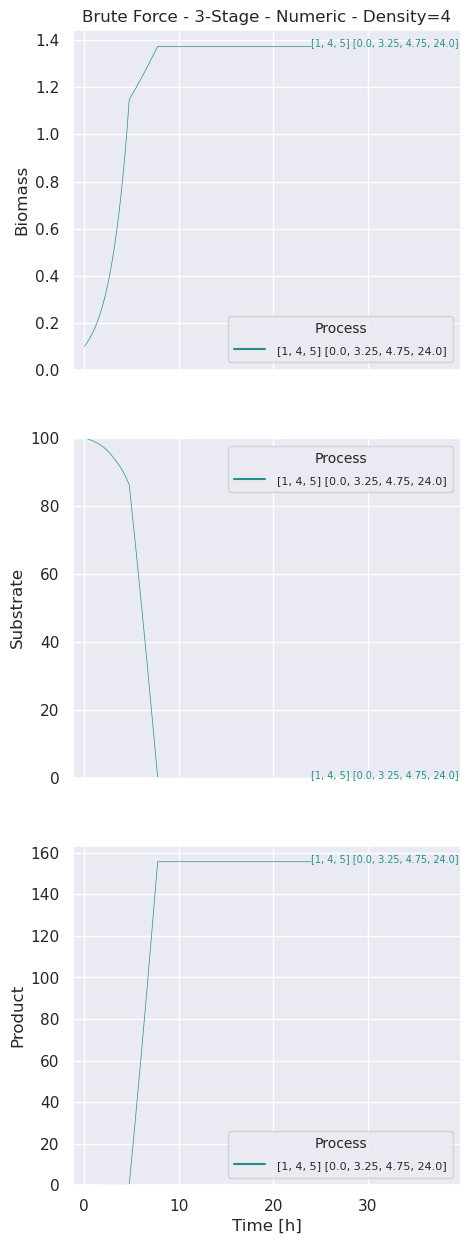

In [45]:
%%time
t_start = 0
t_end = 24
min_duration = 1
n_stages = 3
den = 4
combis = list(itertools.product([0, 1, 2, 3, 4, 5], [0, 1, 2, 3, 4, 5], [0, 1, 2, 3, 4, 5]))  # all combinations for 2-stage: [(0, 0), (0, 1), ... , (5, 5)]

BruteForceNumeric_3Stage_den4 = msp.do_brute_force_num(combis, models_numeric, n_stages, t_start, t_end, min_duration, s, density = den)
display(BruteForceNumeric_3Stage_den4)

BruteForceNumeric_3Stage_den4_best = (BruteForceNumeric_3Stage_den4.sort_values(["Vol_P"], ascending=[False]).dropna(axis=0).drop_duplicates(subset="Models", keep="first")[:1])
display(BruteForceNumeric_3Stage_den4_best)
msp.do_custom_plot(df=BruteForceNumeric_3Stage_den4_best, models_num=models_numeric, s=s, title="Brute Force - 3-Stage - Numeric - Density=4")

___

# Optimizer

## Two-Stage fermentation  - Analytic
(could be seen as strain comparison)

In [25]:
%%time
models_analytic = [WT_aerob_growth_analyt,
                 WT_anaerob_growth_analyt, 
                 WT_anaerob_growth_arrest_analyt]

models_numeric = [WT_aerob_growth,
                 WT_anaerob_growth, 
                 WT_anaerob_growth_arrest]

def objective(self, x):
    combi=list(x[(self.max_stage-1):len(x)])
    models=self.models
    s0=self.y
    times=[self.tstart]+list(x[0:(self.max_stage-1)])+[self.tend]
    res=[]
    finished=0
    while len(times)>1:
        finished= finished+1
        # Get substrate, product, biomass and end time values for the given stage 
        res = models[int(combi[0])](s0, times[0], times[1])
        combi.pop(0)
        times.pop(0)
        if((times[0]-res[-1]) < 1e-9):       # next stage (check if substrate went out before stage duration finished)
            if(len(times)==1):              # if t_end is reached -> stop
                res=res+[np.Inf]
                break
            s0= res[0:-1]
        else:                               # fermentation finished before last stage        
            res=res+[finished]
            break

    ## Objective
    # max. Vol. Productivity
    score = -res[P]/(res[(len(res)-2)]-self.tstart)  
    return score 

algo_ihs = algorithm(ihs(gen=2500, seed=12345))  # total numer of evaluations = 10 + 1000
algo_ihs.set_verbosity(500)  # output best performing each 50th generation

OptimizerAnalytic_2Stage_1to3_Prob = problem(decorator_problem(msp.Optimizer(
            s=s,
            models=models_analytic,
            tstart=0,
            tend=24,
            max_stage=2,
            min_duration=1,
            objective=objective
        ),
        fitness_decorator=msp.f_log_decor,
    )
)

OptimizerAnalytic_2Stage_1to3 = algo_ihs.evolve(population(OptimizerAnalytic_2Stage_1to3_Prob, size=10, seed=12345))  
#msp.do_save(OptimizerAnalytic_2Stage_1to3, './Results/Computer_Stg2_ana_opt_1to3.pickle')




Fevals:          ppar:            bw:            dx:            df:      Violated:    Viol. Norm:        ideal1:
      1       0.350256       0.995405        3.87121        9.42197              0              0       -9.54862
    501       0.478256      0.0995405              0              0              0              0       -16.5679
   1001       0.606256     0.00995405              0              0              0              0        -16.578
   1501       0.734256    0.000995405     0.00257845    3.07675e-06              0              0       -16.5781
   2001       0.862256    9.95405e-05    0.000376865    1.46069e-07              0              0       -16.5781
CPU times: user 57.1 ms, sys: 12 ms, total: 69.1 ms
Wall time: 64.9 ms


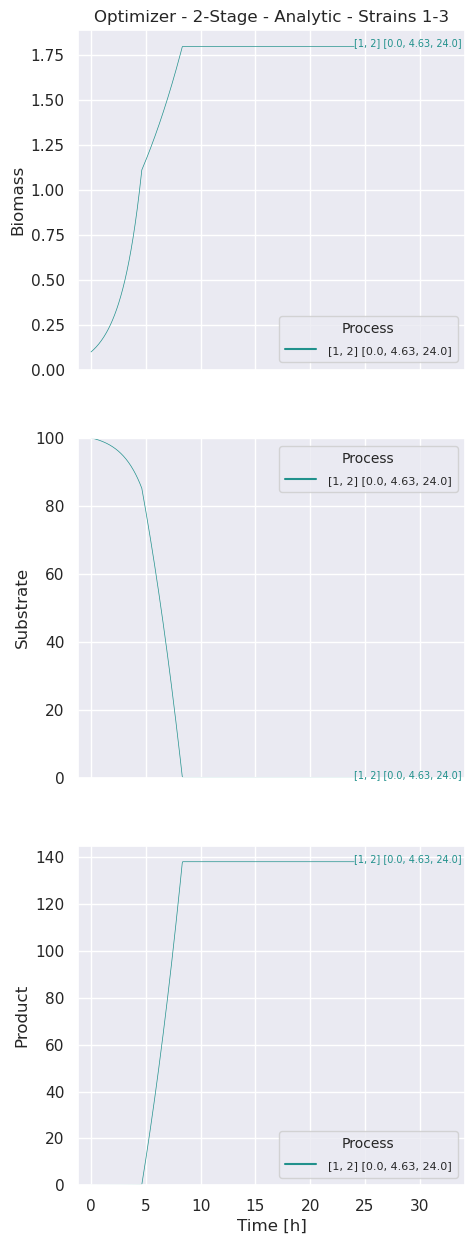

In [26]:

OptimizerAnalytic_2Stage_1to3_best = msp.do_opt_to_df(pd.DataFrame(OptimizerAnalytic_2Stage_1to3.problem.extract(decorator_problem).dv_log), n_best=1)
msp.do_custom_plot(df=msp.do_convert(OptimizerAnalytic_2Stage_1to3_best, models_numeric, 0, 24, s), models_num=models_numeric, s=s, title="Optimizer - 2-Stage - Analytic - Strains 1-3")

Modules below showing 1, 2, 3 but are if taken all modules in order 4, 5, 6

In [27]:
%%time
models_analytic = [LC_aerob_growth_analyt,
                 LC_anaerob_growth_analyt, 
                 LC_anaerob_growth_arrest_analyt]

models_numeric = [      LC_aerob_growth,
                        LC_anaerob_growth, 
                        LC_anaerob_growth_arrest]

def objective(self, x):
    combi=list(x[(self.max_stage-1):len(x)])
    models=self.models
    s0=self.y
    times=[self.tstart]+list(x[0:(self.max_stage-1)])+[self.tend]
    res=[]
    finished=0
    while len(times)>1:
        finished= finished+1
        # Get substrate, product, biomass and end time values for the given stage 
        res = models[int(combi[0])](s0, times[0], times[1])
        combi.pop(0)
        times.pop(0)
        if((times[0]-res[-1]) < 1e-9):       # next stage (check if substrate went out before stage duration finished)
            if(len(times)==1):              # if t_end is reached -> stop
                res=res+[np.Inf]
                break
            s0= res[0:-1]
        else:                               # fermentation finished before last stage        
            res=res+[finished]
            break
    ## Objective
    # max. Vol. Productivity
    score = -res[P]/(res[(len(res)-2)]-self.tstart)  
    return score 

algo_ihs = algorithm(ihs(gen=2500, seed=12345))  # total numer of evaluations = 10 + 1000
algo_ihs.set_verbosity(500)  # output best performing each 50th generation

OptimizerAnalytic_2Stage_4to6_Prob = problem(decorator_problem(msp.Optimizer(
            s=s,
            models=models_analytic,
            tstart=0,
            tend=24,
            max_stage=2,
            min_duration=1,
            objective=objective
        ),
        fitness_decorator=msp.f_log_decor,
    )
)

OptimizerAnalytic_2Stage_4to6 = algo_ihs.evolve(population(OptimizerAnalytic_2Stage_4to6_Prob, size=10, seed=12345))  
#msp.do_save(OptimizerAnalytic_2Stage_4to6, './Results/Computer_Stg2_ana_opt_4to6.pickle')



Fevals:          ppar:            bw:            dx:            df:      Violated:    Viol. Norm:        ideal1:
      1       0.350256       0.995405        15.0652        10.3677              0              0       -11.8026
    501       0.478256      0.0995405              0              0              0              0       -19.9191
   1001       0.606256     0.00995405              0              0              0              0       -19.9197
   1501       0.734256    0.000995405    9.59496e-05    2.56216e-08              0              0       -19.9197
   2001       0.862256    9.95405e-05    8.50852e-05    4.07037e-09              0              0       -19.9197
CPU times: user 59.5 ms, sys: 4 ms, total: 63.5 ms
Wall time: 61.7 ms


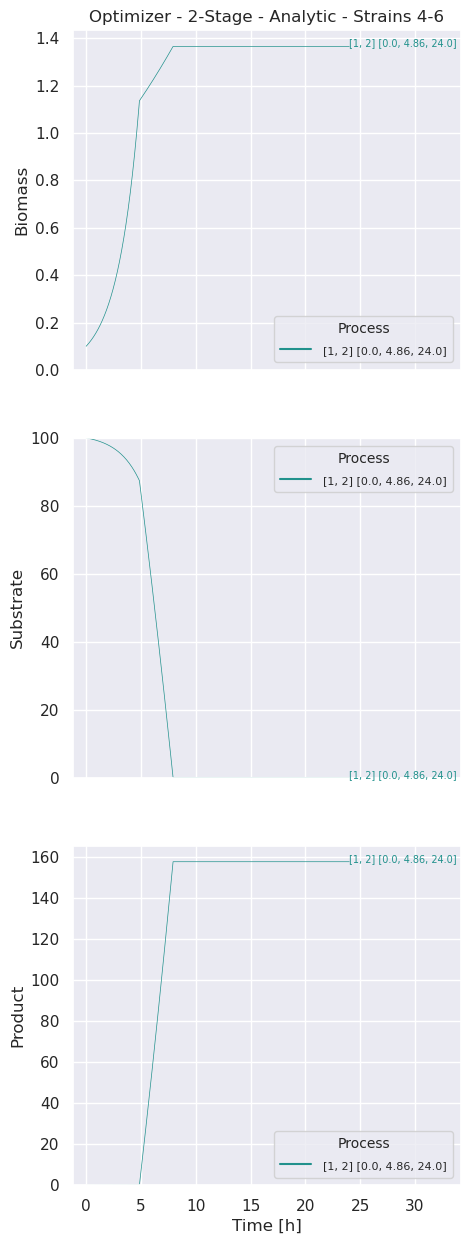

In [28]:

OptimizerAnalytic_2Stage_4to6_best = msp.do_opt_to_df(pd.DataFrame(OptimizerAnalytic_2Stage_4to6.problem.extract(decorator_problem).dv_log), n_best=1)
msp.do_custom_plot(df=msp.do_convert(OptimizerAnalytic_2Stage_4to6_best, models_numeric, 0, 24, s), models_num=models_numeric, s=s, title="Optimizer - 2-Stage - Analytic - Strains 4-6")


## Two-Stage fermentation  - Numeric
(could be seen as strain comparison)

In [29]:
%%time
models_numeric = [  WT_aerob_growth,
                    WT_anaerob_growth, 
                    WT_anaerob_growth_arrest]

def objective(self, x):
    combi=list(x[(self.max_stage-1):len(x)])
    models=self.models
    s0=self.y
    times=[self.tstart]+list(x[0:(self.max_stage-1)])+[self.tend]
    finished=0
    res=[]
    step=self.step
    while len(times)>1:
        finished= finished+1
        r = sp.integrate.solve_ivp(models[int(combi[0])], t_span=[times[0], times[1]], y0=s0, t_eval=[times[1]], events=[msp.event_sub0, msp.event_prod85percent], dense_output=True, max_step=step)

        try:    # Case in which event triggers and fermentation stopps before tend
            res = [ r.y_events[0][0][species] for species in range(len(s)) ]
            res = res + [r.t_events[0][0]]
        except: # Case in which fermentation runs until tend
            res = [ r.y[species][0] for species in range(len(s)) ]
            res = res + [r.t[0]]
        ## Drop the first element from combination and time
        # e.g.          (0,1,2) and (0.0, 2.0, 3.0, 24.0)
        # will become   (  1,2) and (     2.0, 3.0, 24.0)
        combi.pop(0)
        times.pop(0)

        if((times[0]-res[-1]) < 1e-9):       # next stage 
            if(len(times)==1):              # if t_end is reached -> stop
                res=res+[np.Inf]
                break
            s0=res[:-1]
        else:                               # fermentation finished before last stage        
            res=res+[finished]
            break
    ## Objective
    # max. Vol. Productivity
    score = -res[P]/(res[(len(res)-2)]-self.tstart)  
    return score 

algo_ihs = algorithm(ihs(gen=2500, seed=12345))  # total numer of evaluations = 10 + 1000
algo_ihs.set_verbosity(500)  # output best performing each 50th generation

OptimizerNumeric_2Stage_1to3_Prob = problem(decorator_problem(msp.Optimizer(
            s=s,
            models=models_numeric,
            tstart=0,
            tend=24,
            max_stage=2,
            min_duration=1,
            objective=objective
        ),
        fitness_decorator=msp.f_log_decor,
    )
)

OptimizerNumeric_2Stage_1to3 = algo_ihs.evolve(population(OptimizerNumeric_2Stage_1to3_Prob, size=10, seed=12345))  # start with 10 candidate solutions
#msp.do_save(OptimizerNumeric_2Stage_1to3, './Results/Computer_Stg2_num_opt_1to3.pickle')




Fevals:          ppar:            bw:            dx:            df:      Violated:    Viol. Norm:        ideal1:
      1       0.350256       0.995405        3.87121         9.4219              0              0       -9.54855
    501       0.478256      0.0995405              0              0              0              0        -16.571
   1001       0.606256     0.00995405     0.00430978    6.13509e-06              0              0       -16.5779
   1501       0.734256    0.000995405    0.000278097    2.97726e-05              0              0        -16.578
   2001       0.862256    9.95405e-05              0              0              0              0        -16.578
CPU times: user 11min 32s, sys: 3.99 ms, total: 11min 32s
Wall time: 11min 32s


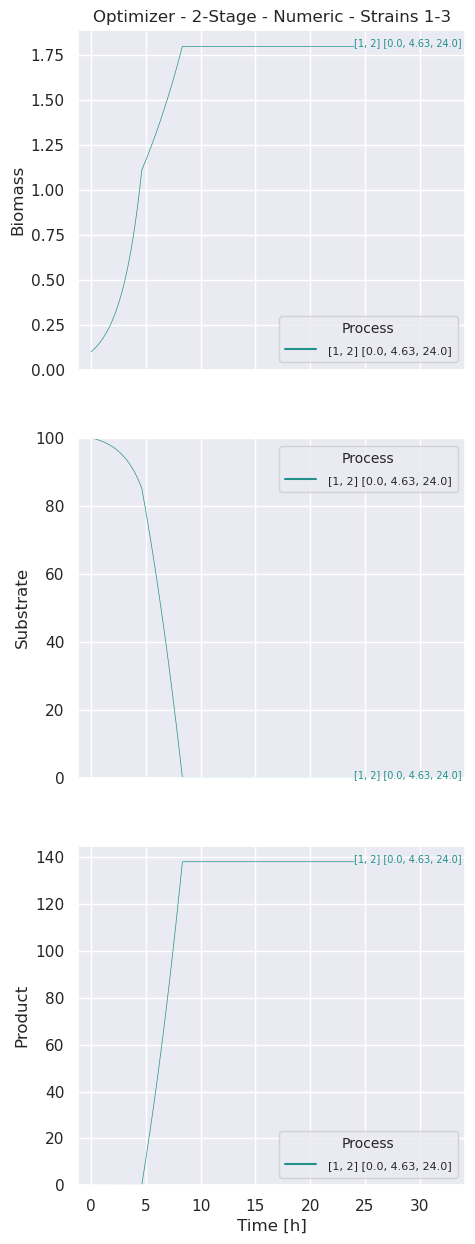

In [30]:
OptimizerNumeric_2Stage_1to3_best = msp.do_opt_to_df(pd.DataFrame(OptimizerNumeric_2Stage_1to3.problem.extract(decorator_problem).dv_log), n_best=1)
msp.do_custom_plot(df=msp.do_convert(OptimizerNumeric_2Stage_1to3_best, models_numeric, 0, 24, s), models_num=models_numeric, s=s, title="Optimizer - 2-Stage - Numeric - Strains 1-3")

In [31]:
%%time
models_numeric = [  LC_aerob_growth,
                    LC_anaerob_growth, 
                    LC_anaerob_growth_arrest]

def objective(self, x):
    combi=list(x[(self.max_stage-1):len(x)])
    models=self.models
    s0=self.y
    times=[self.tstart]+list(x[0:(self.max_stage-1)])+[self.tend]
    finished=0
    res=[]
    step=self.step
    while len(times)>1:
        finished= finished+1
        r = sp.integrate.solve_ivp(models[int(combi[0])], t_span=[times[0], times[1]], y0=s0, t_eval=[times[1]], events=[msp.event_sub0, msp.event_prod85percent], dense_output=True, max_step=step)

        try:    # Case in which event triggers and fermentation stopps before tend
            res = [ r.y_events[0][0][species] for species in range(len(s)) ]
            res = res + [r.t_events[0][0]]
        except: # Case in which fermentation runs until tend
            res = [ r.y[species][0] for species in range(len(s)) ]
            res = res + [r.t[0]]
        ## Drop the first element from combination and time
        # e.g.          (0,1,2) and (0.0, 2.0, 3.0, 24.0)
        # will become   (  1,2) and (     2.0, 3.0, 24.0)
        combi.pop(0)
        times.pop(0)

        if((times[0]-res[-1]) < 1e-9):       # next stage 
            if(len(times)==1):              # if t_end is reached -> stop
                res=res+[np.Inf]
                break
            s0=res[:-1]
        else:                               # fermentation finished before last stage        
            res=res+[finished]
            break
    ## Objective
    # max. Vol. Productivity
    score = -res[P]/(res[(len(res)-2)]-self.tstart)  
    return score 

algo_ihs = algorithm(ihs(gen=2500, seed=12345))  # total numer of evaluations = 10 + 1000
algo_ihs.set_verbosity(500)  # output best performing each 50th generation

OptimizerNumeric_2Stage_4to6_Prob = problem(decorator_problem(msp.Optimizer(
            s=s,
            models=models_numeric,
            tstart=0,
            tend=24,
            max_stage=2,
            min_duration=1,
            objective=objective
        ),
        fitness_decorator=msp.f_log_decor,
    )
)

OptimizerNumeric_2Stage_4to6 = algo_ihs.evolve(population(OptimizerNumeric_2Stage_4to6_Prob, size=10, seed=12345))  
#msp.do_save(OptimizerNumeric_2Stage_4to6, './Results/Computer_Stg2_num_opt_4to6.pickle')



Fevals:          ppar:            bw:            dx:            df:      Violated:    Viol. Norm:        ideal1:
      1       0.350256       0.995405        15.0652        10.3675              0              0       -11.8024
    501       0.478256      0.0995405              0              0              0              0        -19.919
   1001       0.606256     0.00995405              0              0              0              0       -19.9195
   1501       0.734256    0.000995405    0.000278097    8.50774e-06              0              0       -19.9196
   2001       0.862256    9.95405e-05    0.000943645    8.07961e-06              0              0       -19.9196
CPU times: user 11min 21s, sys: 0 ns, total: 11min 21s
Wall time: 11min 21s


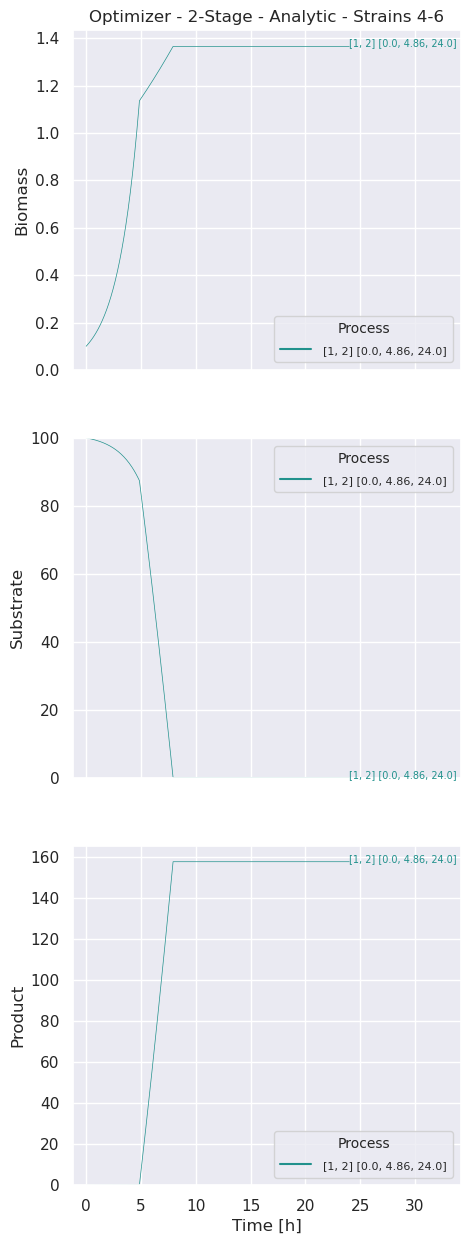

In [32]:
OptimizerNumeric_2Stage_4to6_best = msp.do_opt_to_df(pd.DataFrame(OptimizerNumeric_2Stage_4to6.problem.extract(decorator_problem).dv_log), n_best=1)
msp.do_custom_plot(df=msp.do_convert(OptimizerNumeric_2Stage_4to6_best, models_numeric, 0, 24, s), models_num=models_numeric, s=s, title="Optimizer - 2-Stage - Analytic - Strains 4-6")

## Two-Stage fermentation (all modules) - Analytic


Fevals:          ppar:            bw:            dx:            df:      Violated:    Viol. Norm:        ideal1:
      1       0.350128         0.9977         16.421        9.39983              0              0       -9.54862
    501       0.414128         0.3155      0.0302282     0.00339476              0              0       -20.0283
   1001       0.478128        0.09977              0              0              0              0       -20.0283
   1501       0.542128        0.03155              0              0              0              0       -20.0283
   2001       0.606128       0.009977              0              0              0              0       -20.0291
   2501       0.670128       0.003155              0              0              0              0       -20.0291
   3001       0.734128      0.0009977     0.00405164    8.43445e-06              0              0       -20.0291
   3501       0.798128      0.0003155     0.00127145    2.46909e-06              0             

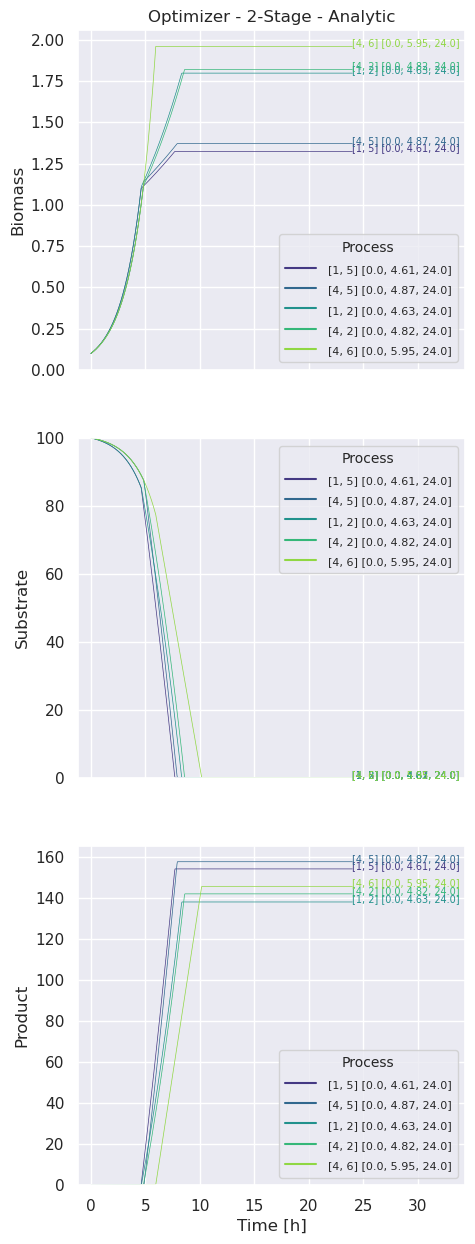

In [33]:
%%time

models_numeric = [WT_aerob_growth,
                 WT_anaerob_growth, 
                 WT_anaerob_growth_arrest,
                 LC_aerob_growth,
                 LC_anaerob_growth, 
                 LC_anaerob_growth_arrest]

models_analytic = [WT_aerob_growth_analyt,
                 WT_anaerob_growth_analyt, 
                 WT_anaerob_growth_arrest_analyt,
                 LC_aerob_growth_analyt,
                 LC_anaerob_growth_analyt, 
                 LC_anaerob_growth_arrest_analyt]

def objective(self, x):
    combi=list(x[(self.max_stage-1):len(x)])
    models=self.models
    s0=self.y
    times=[self.tstart]+list(x[0:(self.max_stage-1)])+[self.tend]
    res=[]
    finished=0
    while len(times)>1:
        finished= finished+1
        # Get substrate, product, biomass and end time values for the given stage 
        res = models[int(combi[0])](s0, times[0], times[1])
        combi.pop(0)
        times.pop(0)
        if((times[0]-res[-1]) < 1e-9):       # next stage (check if substrate went out before stage duration finished)
            if(len(times)==1):              # if t_end is reached -> stop
                res=res+[np.Inf]
                break
            s0= res[0:-1]
        else:                               # fermentation finished before last stage        
            res=res+[finished]
            break
    ## Objective
    # max. Vol. Productivity
    score = -res[P]/(res[(len(res)-2)]-self.tstart)       
    return score

algo_ihs = algorithm(ihs(gen=5000, seed=12345))  # total numer of evaluations = 10 + 1000
algo_ihs.set_verbosity(500)  # output best performing each 50th generation

OptimizerAnalytic_2Stage_Prob = problem(decorator_problem(msp.Optimizer(
            s=s,
            models=models_analytic,
            tstart=0,
            tend=24,
            max_stage=2,
            min_duration=1,
            objective=objective
        ),
        fitness_decorator=msp.f_log_decor,
    )
)

OptimizerAnalytic_2Stage = algo_ihs.evolve(population(OptimizerAnalytic_2Stage_Prob, size=10, seed=12345)) 
#msp.do_save(OptimizerAnalytic_2Stage, './Results/Computer_Stg2_ana_opt_All.pickle')

OptimizerAnalytic_2Stage_best = msp.do_opt_to_df(pd.DataFrame(OptimizerAnalytic_2Stage.problem.extract(decorator_problem).dv_log), n_best=5)
msp.do_custom_plot(df=msp.do_convert(OptimizerAnalytic_2Stage_best, models_numeric, 0, 24, s), models_num=models_numeric, s=s, title="Optimizer - 2-Stage - Analytic")


## Two-Stage fermentation (all modules) - Numeric


Fevals:          ppar:            bw:            dx:            df:      Violated:    Viol. Norm:        ideal1:
      1       0.350128         0.9977         16.421        9.39977              0              0       -9.54855


    501       0.414128         0.3155      0.0302282     0.00336913              0              0       -20.0281
   1001       0.478128        0.09977              0              0              0              0       -20.0281
   1501       0.542128        0.03155              0              0              0              0       -20.0281
   2001       0.606128       0.009977              0              0              0              0        -20.029
   2501       0.670128       0.003155              0              0              0              0        -20.029
   3001       0.734128      0.0009977              0              0              0              0        -20.029
   3501       0.798128      0.0003155     0.00311861    4.78315e-05              0              0        -20.029
   4001       0.862128      9.977e-05     0.00119317    3.70268e-05              0              0        -20.029
   4501       0.926128      3.155e-05    0.000324647    3.22699e-05              0              

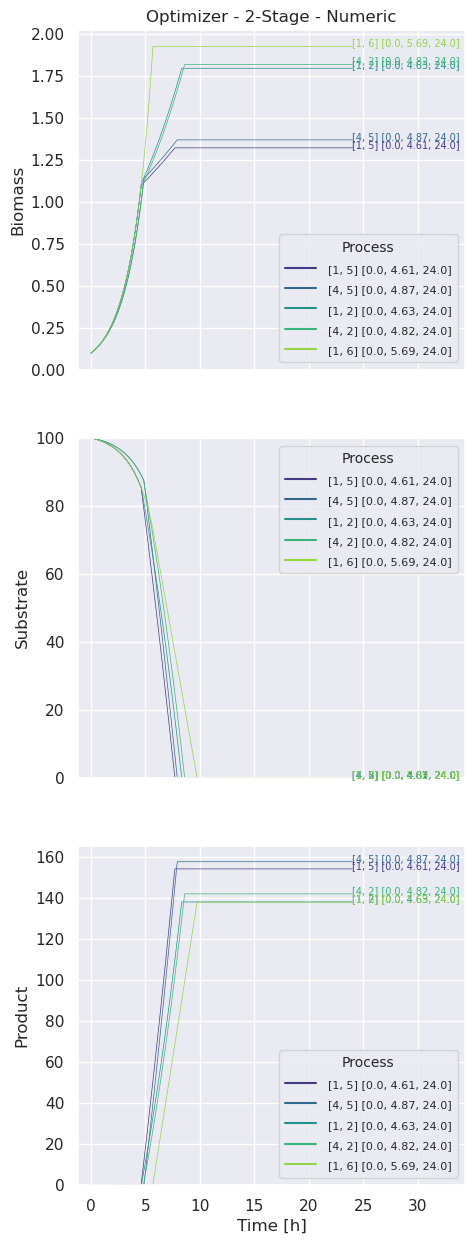

In [34]:
%%time

models_numeric = [WT_aerob_growth,
                 WT_anaerob_growth, 
                 WT_anaerob_growth_arrest,
                 LC_aerob_growth,
                 LC_anaerob_growth, 
                 LC_anaerob_growth_arrest]

models_analytic = [WT_aerob_growth_analyt,
                 WT_anaerob_growth_analyt, 
                 WT_anaerob_growth_arrest_analyt,
                 LC_aerob_growth_analyt,
                 LC_anaerob_growth_analyt, 
                 LC_anaerob_growth_arrest_analyt]

def objective(self, x):
    combi=list(x[(self.max_stage-1):len(x)])
    models=self.models
    s0=self.y
    times=[self.tstart]+list(x[0:(self.max_stage-1)])+[self.tend]
    finished=0
    res=[]
    step=self.step
    while len(times)>1:
        finished= finished+1
        r = sp.integrate.solve_ivp(models[int(combi[0])], t_span=[times[0], times[1]], y0=s0, t_eval=[times[1]], events=[msp.event_sub0, msp.event_prod85percent], dense_output=True, max_step=step)

        try:    # Case in which event triggers and fermentation stopps before tend
            res = [ r.y_events[0][0][species] for species in range(len(s)) ]
            res = res + [r.t_events[0][0]]
        except: # Case in which fermentation runs until tend
            res = [ r.y[species][0] for species in range(len(s)) ]
            res = res + [r.t[0]]
        ## Drop the first element from combination and time
        # e.g.          (0,1,2) and (0.0, 2.0, 3.0, 24.0)
        # will become   (  1,2) and (     2.0, 3.0, 24.0)
        combi.pop(0)
        times.pop(0)

        if((times[0]-res[-1]) < 1e-9):       # next stage 
            if(len(times)==1):              # if t_end is reached -> stop
                res=res+[np.Inf]
                break
            s0=res[:-1]
        else:                               # fermentation finished before last stage        
            res=res+[finished]
            break
    ## Objective
    # max. Vol. Productivity
    score = -res[P]/(res[(len(res)-2)]-self.tstart)       
    return score

algo_ihs = algorithm(ihs(gen=5000, seed=12345))  # total numer of evaluations = 10 + 1000
algo_ihs.set_verbosity(500)  # output best performing each 50th generation

OptimizerNumeric_2Stage_Prob = problem(decorator_problem(msp.Optimizer(
            s=s,
            models=models_numeric,
            tstart=0,
            tend=24,
            max_stage=2,
            min_duration=1,
            objective=objective
        ),
        fitness_decorator=msp.f_log_decor,
    )
)

OptimizerNumeric_2Stage = algo_ihs.evolve(population(OptimizerNumeric_2Stage_Prob, size=10, seed=12345))
#msp.do_save(OptimizerNumeric_2Stage, './Results/Computer_Stg2_num_opt_All.pickle')

OptimizerNumeric_2Stage_best = msp.do_opt_to_df(pd.DataFrame(OptimizerNumeric_2Stage.problem.extract(decorator_problem).dv_log), n_best=5)
msp.do_custom_plot(df=msp.do_convert(OptimizerNumeric_2Stage_best, models_numeric, 0, 24, s), models_num=models_numeric, s=s, title="Optimizer - 2-Stage - Numeric")


## Three-Stage fermentation  - Analytic
(could be seen as strain comparison)

### For Ecolac (strain without ATP wasting):


Fevals:          ppar:            bw:            dx:            df:      Violated:    Viol. Norm:        ideal1:
      1       0.350013        0.99977        25.5675        4.48651              0              0       -4.48651
    501       0.356413       0.891046        7.29105     0.00585503              0              0       -16.5772
   1001       0.362813       0.794145        5.21339              0              0              0       -16.5779
   1501       0.369213       0.707783       0.892432    3.55271e-15              0              0       -16.5779
   2001       0.375613       0.630812              0              0              0              0       -16.5779
   2501       0.382013       0.562212              0              0              0              0       -16.5779
   3001       0.388413       0.501072              0              0              0              0       -16.5779
   3501       0.394813       0.446581              0              0              0             

CPU times: user 6.24 s, sys: 200 ms, total: 6.44 s
Wall time: 6.15 s


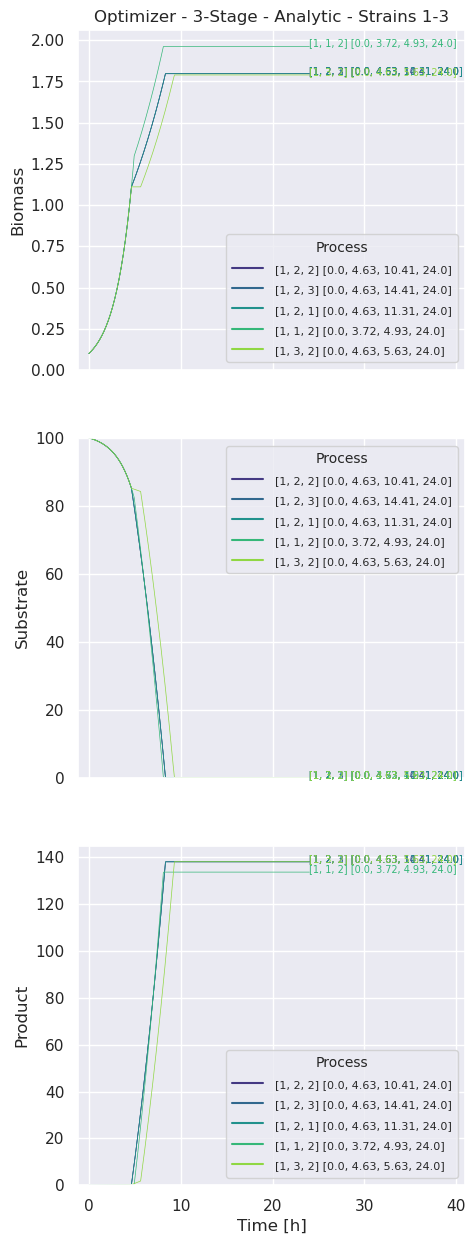

In [35]:
%%time
models_analytic = [WT_aerob_growth_analyt,
                 WT_anaerob_growth_analyt, 
                 WT_anaerob_growth_arrest_analyt]

models_numeric = [WT_aerob_growth,
                 WT_anaerob_growth, 
                 WT_anaerob_growth_arrest]

def objective(self, x):
    combi=list(x[(self.max_stage-1):len(x)])
    models=self.models
    s0=self.y
    times=[self.tstart]+list(x[0:(self.max_stage-1)])+[self.tend]
    res=[]
    finished=0
    while len(times)>1:
        finished= finished+1
        # Get substrate, product, biomass and end time values for the given stage 
        res = models[int(combi[0])](s0, times[0], times[1])
        combi.pop(0)
        times.pop(0)
        if((times[0]-res[-1]) < 1e-9):       # next stage (check if substrate went out before stage duration finished)
            if(len(times)==1):              # if t_end is reached -> stop
                res=res+[np.Inf]
                break
            s0= res[0:-1]
        else:                               # fermentation finished before last stage        
            res=res+[finished]
            break
    ## Objective
    # max. Vol. Productivity
    score = -res[P]/(res[(len(res)-2)]-self.tstart)  
    return score 

algo_ihs = algorithm(ihs(gen=50000, seed=12345))  # total numer of evaluations = 10 + 1000
algo_ihs.set_verbosity(500)  # output best performing each 50th generation

OptimizerAnalytic_3Stage_1to3_Prob = problem(decorator_problem(msp.Optimizer(
            s=s,
            models=models_analytic,
            tstart=0,
            tend=24,
            max_stage=3,
            min_duration=1,
            objective=objective
        ),
        fitness_decorator=msp.f_log_decor,
    )
)

OptimizerAnalytic_3Stage_1to3 = algo_ihs.evolve(population(OptimizerAnalytic_3Stage_1to3_Prob, size=10, seed=12345))  
#msp.do_save(OptimizerAnalytic_3Stage_1to3, './Results/Computer_Stg3_ana_opt_1to3.pickle')

OptimizerAnalytic_3Stage_1to3_best = msp.do_opt_to_df(pd.DataFrame(OptimizerAnalytic_3Stage_1to3.problem.extract(decorator_problem).dv_log), n_best=5)
msp.do_custom_plot(df=msp.do_convert(OptimizerAnalytic_3Stage_1to3_best, models_numeric, 0, 24, s), models_num=models_numeric, s=s, title="Optimizer - 3-Stage - Analytic - Strains 1-3")


### For EcolacATPase (strain with ATP wasting):


Fevals:          ppar:            bw:            dx:            df:      Violated:    Viol. Norm:        ideal1:
      1       0.350013        0.99977        25.5675        4.55281              0              0       -4.55281
    501       0.356413       0.891046        10.4792    1.06581e-14              0              0       -19.9174
   1001       0.362813       0.794145      0.0358127    3.55271e-15              0              0       -19.9181
   1501       0.369213       0.707783              0              0              0              0       -19.9181
   2001       0.375613       0.630812              0              0              0              0       -19.9181
   2501       0.382013       0.562212              0              0              0              0       -19.9181
   3001       0.388413       0.501072              0              0              0              0       -19.9181
   3501       0.394813       0.446581              0              0              0             

CPU times: user 6.36 s, sys: 200 ms, total: 6.56 s
Wall time: 6.31 s


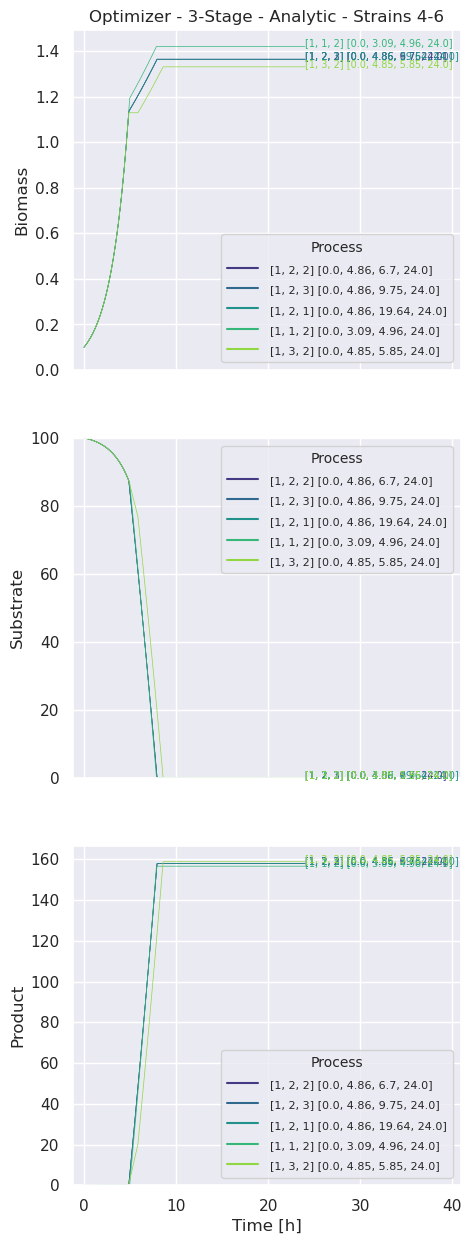

In [36]:
%%time
models_analytic = [LC_aerob_growth_analyt,
                 LC_anaerob_growth_analyt, 
                 LC_anaerob_growth_arrest_analyt]

models_numeric = [      LC_aerob_growth,
                        LC_anaerob_growth, 
                        LC_anaerob_growth_arrest]

def objective(self, x):
    combi=list(x[(self.max_stage-1):len(x)])
    models=self.models
    s0=self.y
    times=[self.tstart]+list(x[0:(self.max_stage-1)])+[self.tend]
    res=[]
    finished=0
    while len(times)>1:
        finished= finished+1
        # Get substrate, product, biomass and end time values for the given stage 
        res = models[int(combi[0])](s0, times[0], times[1])
        combi.pop(0)
        times.pop(0)
        if((times[0]-res[-1]) < 1e-9):       # next stage (check if substrate went out before stage duration finished)
            if(len(times)==1):              # if t_end is reached -> stop
                res=res+[np.Inf]
                break
            s0= res[0:-1]
        else:                               # fermentation finished before last stage        
            res=res+[finished]
            break
    ## Objective
    # max. Vol. Productivity
    score = -res[P]/(res[(len(res)-2)]-self.tstart)  
    return score 

algo_ihs = algorithm(ihs(gen=50000, seed=12345))  # total numer of evaluations = 10 + 1000
algo_ihs.set_verbosity(500)  # output best performing each 50th generation

OptimizerAnalytic_3Stage_4to6_Prob = problem(decorator_problem(msp.Optimizer(
            s=s,
            models=models_analytic,
            tstart=0,
            tend=24,
            max_stage=3,
            min_duration=1,
            objective=objective
        ),
        fitness_decorator=msp.f_log_decor,
    )
)

OptimizerAnalytic_3Stage_4to6 = algo_ihs.evolve(population(OptimizerAnalytic_3Stage_4to6_Prob, size=10, seed=12345))  
#msp.do_save(OptimizerAnalytic_3Stage_4to6, './Results/Computer_Stg3_ana_opt_4to6.pickle')

OptimizerAnalytic_3Stage_4to6_best = msp.do_opt_to_df(pd.DataFrame(OptimizerAnalytic_3Stage_4to6.problem.extract(decorator_problem).dv_log), n_best=5)
msp.do_custom_plot(df=msp.do_convert(OptimizerAnalytic_3Stage_4to6_best, models_numeric, 0, 24, s), models_num=models_numeric, s=s, title="Optimizer - 3-Stage - Analytic - Strains 4-6")


## Three-Stage fermentation  - Numeric
(could be seen as strain comparison)

### For Ecolac (strain without ATP wasting):


Fevals:          ppar:            bw:            dx:            df:      Violated:    Viol. Norm:        ideal1:
      1       0.350013        0.99977        25.5675        4.48651              0              0       -4.48651


  10001       0.478013       0.099977              0              0              0              0        -16.578
  20001       0.606013      0.0099977        14.7089    1.62937e-06              0              0        -16.578
  30001       0.734013     0.00099977              0              0              0              0        -16.578
  40001       0.862013     9.9977e-05              0              0              0              0        -16.578
CPU times: user 2h 58min 2s, sys: 196 ms, total: 2h 58min 2s
Wall time: 2h 58min 2s


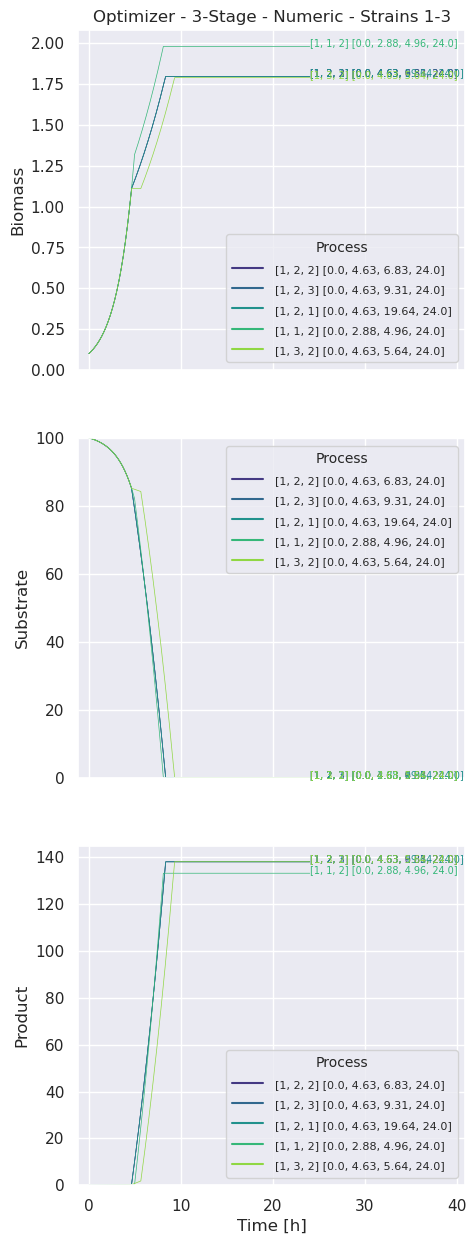

In [37]:
%%time
models_numeric = [  WT_aerob_growth,
                    WT_anaerob_growth, 
                    WT_anaerob_growth_arrest]

def objective(self, x):
    combi=list(x[(self.max_stage-1):len(x)])
    models=self.models
    s0=self.y
    times=[self.tstart]+list(x[0:(self.max_stage-1)])+[self.tend]
    finished=0
    res=[]
    step=self.step
    while len(times)>1:
        finished= finished+1
        r = sp.integrate.solve_ivp(models[int(combi[0])], t_span=[times[0], times[1]], y0=s0, t_eval=[times[1]], events=[msp.event_sub0, msp.event_prod85percent], dense_output=True, max_step=step)

        try:    # Case in which event triggers and fermentation stopps before tend
            res = [ r.y_events[0][0][species] for species in range(len(s)) ]
            res = res + [r.t_events[0][0]]
        except: # Case in which fermentation runs until tend
            res = [ r.y[species][0] for species in range(len(s)) ]
            res = res + [r.t[0]]
        ## Drop the first element from combination and time
        # e.g.          (0,1,2) and (0.0, 2.0, 3.0, 24.0)
        # will become   (  1,2) and (     2.0, 3.0, 24.0)
        combi.pop(0)
        times.pop(0)

        if((times[0]-res[-1]) < 1e-9):       # next stage 
            if(len(times)==1):              # if t_end is reached -> stop
                res=res+[np.Inf]
                break
            s0=res[:-1]
        else:                               # fermentation finished before last stage        
            res=res+[finished]
            break
    ## Objective
    # max. Vol. Productivity
    score = -res[P]/(res[(len(res)-2)]-self.tstart)  
    return score 

algo_ihs = algorithm(ihs(gen=50000, seed=12345))  # total numer of evaluations = 10 + 1000
algo_ihs.set_verbosity(10000)  # output best performing each 50th generation

OptimizerNumeric_3Stage_1to3_Prob = problem(decorator_problem(msp.Optimizer(
            s=s,
            models=models_numeric,
            tstart=0,
            tend=24,
            max_stage=3,
            min_duration=1,
            objective=objective
        ),
        fitness_decorator=msp.f_log_decor,
    )
)

OptimizerNumeric_3Stage_1to3 = algo_ihs.evolve(population(OptimizerNumeric_3Stage_1to3_Prob, size=10, seed=12345))  # start with 10 candidate solutions
#msp.do_save(OptimizerNumeric_3Stage_1to3, './Results/Computer_Stg3_num_opt_1to3.pickle')

OptimizerNumeric_3Stage_1to3_best = msp.do_opt_to_df(pd.DataFrame(OptimizerNumeric_3Stage_1to3.problem.extract(decorator_problem).dv_log), n_best=5)
msp.do_custom_plot(df=msp.do_convert(OptimizerNumeric_3Stage_1to3_best, models_numeric, 0, 24, s), models_num=models_numeric, s=s, title="Optimizer - 3-Stage - Numeric - Strains 1-3")


### For EcolacATPase (strain with ATP wasting):

In [38]:
%%time
models_numeric = [  LC_aerob_growth,
                    LC_anaerob_growth, 
                    LC_anaerob_growth_arrest]

def objective(self, x):
    combi=list(x[(self.max_stage-1):len(x)])
    models=self.models
    s0=self.y
    times=[self.tstart]+list(x[0:(self.max_stage-1)])+[self.tend]
    finished=0
    res=[]
    step=self.step
    while len(times)>1:
        finished= finished+1
        r = sp.integrate.solve_ivp(models[int(combi[0])], t_span=[times[0], times[1]], y0=s0, t_eval=[times[1]], events=[msp.event_sub0, msp.event_prod85percent], dense_output=True, max_step=step)

        try:    # Case in which event triggers and fermentation stopps before tend
            res = [ r.y_events[0][0][species] for species in range(len(s)) ]
            res = res + [r.t_events[0][0]]
        except: # Case in which fermentation runs until tend
            res = [ r.y[species][0] for species in range(len(s)) ]
            res = res + [r.t[0]]
        ## Drop the first element from combination and time
        # e.g.          (0,1,2) and (0.0, 2.0, 3.0, 24.0)
        # will become   (  1,2) and (     2.0, 3.0, 24.0)
        combi.pop(0)
        times.pop(0)

        if((times[0]-res[-1]) < 1e-9):       # next stage 
            if(len(times)==1):              # if t_end is reached -> stop
                res=res+[np.Inf]
                break
            s0=res[:-1]
        else:                               # fermentation finished before last stage        
            res=res+[finished]
            break
    ## Objective
    # max. Vol. Productivity
    score = -res[P]/(res[(len(res)-2)]-self.tstart)  
    return score 

algo_ihs = algorithm(ihs(gen=50000, seed=12345))  # total numer of evaluations = 10 + 1000
algo_ihs.set_verbosity(500)  # output best performing each 50th generation

OptimizerNumeric_3Stage_4to6_Prob = problem(decorator_problem(msp.Optimizer(
            s=s,
            models=models_numeric,
            tstart=0,
            tend=24,
            max_stage=3,
            min_duration=1,
            objective=objective
        ),
        fitness_decorator=msp.f_log_decor,
    )
)

OptimizerNumeric_3Stage_4to6 = algo_ihs.evolve(population(OptimizerNumeric_3Stage_4to6_Prob, size=10, seed=12345))  # start with 10 candidate solutions
#msp.do_save(OptimizerNumeric_3Stage_4to6, './Results/Computer_Stg3_num_opt_4to6.pickle')



Fevals:          ppar:            bw:            dx:            df:      Violated:    Viol. Norm:        ideal1:
      1       0.350013        0.99977        25.5675        4.55281              0              0       -4.55281


    501       0.356413       0.891046        10.3808     5.0528e-05              0              0       -19.9172
   1001       0.362813       0.794145       0.352665    1.24168e-05              0              0        -19.918
   1501       0.369213       0.707783              0              0              0              0        -19.918
   2001       0.375613       0.630812       0.759178    1.97732e-06              0              0        -19.918
   2501       0.382013       0.562212              0              0              0              0        -19.918
   3001       0.388413       0.501072       0.220124    1.16164e-06              0              0        -19.918
   3501       0.394813       0.446581        6.83667     0.00151527              0              0       -19.9195
   4001       0.401213       0.398016        8.01463    0.000778776              0              0       -19.9195
   4501       0.407613       0.354732        6.64351    0.000210844              0              

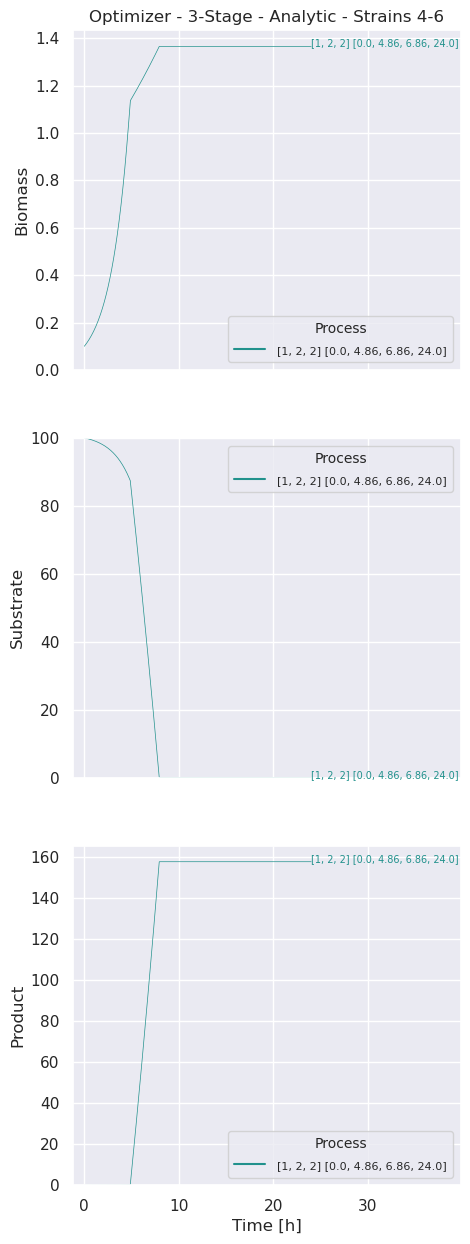

In [39]:
OptimizerNumeric_3Stage_4to6_best = msp.do_opt_to_df(pd.DataFrame(OptimizerNumeric_3Stage_4to6.problem.extract(decorator_problem).dv_log), n_best=1)
msp.do_custom_plot(df=msp.do_convert(OptimizerNumeric_3Stage_4to6_best, models_numeric, 0, 24, s), models_num=models_numeric, s=s, title="Optimizer - 3-Stage - Analytic - Strains 4-6")

## Three-Stage fermentation (all modules)  - Analytic

In [40]:
%%time
models_numeric = [WT_aerob_growth,
                 WT_anaerob_growth, 
                 WT_anaerob_growth_arrest,
                 LC_aerob_growth,
                 LC_anaerob_growth, 
                 LC_anaerob_growth_arrest]

models_analytic = [WT_aerob_growth_analyt,
                 WT_anaerob_growth_analyt, 
                 WT_anaerob_growth_arrest_analyt,
                 LC_aerob_growth_analyt,
                 LC_anaerob_growth_analyt, 
                 LC_anaerob_growth_arrest_analyt]

def objective(self, x):
    combi=list(x[(self.max_stage-1):len(x)])
    models=self.models
    s0=self.y
    times=[self.tstart]+list(x[0:(self.max_stage-1)])+[self.tend]
    res=[]
    finished=0
    while len(times)>1:
        finished= finished+1
        # Get substrate, product, biomass and end time values for the given stage 
        res = models[int(combi[0])](s0, times[0], times[1])
        combi.pop(0)
        times.pop(0)
        if((times[0]-res[-1]) < 1e-9):       # next stage (check if substrate went out before stage duration finished)
            if(len(times)==1):              # if t_end is reached -> stop
                res=res+[np.Inf]
                break
            s0= res[0:-1]
        else:                               # fermentation finished before last stage        
            res=res+[finished]
            break
    ## Objective
    # max. Vol. Productivity
    score = -res[P]/(res[(len(res)-2)]-self.tstart)  
    return score 

algo_ihs = algorithm(ihs(gen=100000, seed=12345))  # total numer of evaluations = 10 + 1000
algo_ihs.set_verbosity(10000)  # output best performing each 50th generation

OptimizerAnalytic_3Stage_Prob = problem(decorator_problem(msp.Optimizer(
            s=s,
            models=models_analytic,
            tstart=0,
            tend=24,
            max_stage=3,
            min_duration=1,
            objective=objective
        ),
        fitness_decorator=msp.f_log_decor,
    )
)
OptimizerAnalytic_3Stage_Prob.c_tol = 1e-3

OptimizerAnalytic_3Stage = algo_ihs.evolve(population(OptimizerAnalytic_3Stage_Prob, size=10, seed=12345))  # start with 10 candidate solutions
#msp.do_save(OptimizerAnalytic_3Stage, './Results/Computer_Stg3_ana_opt_All.pickle')


Fevals:          ppar:            bw:            dx:            df:      Violated:    Viol. Norm:        ideal1:
      1       0.350006       0.999885        30.0108        9.74465              0              0       -9.74465
  10001       0.414006       0.316191              0              0              0              0       -20.0287
  20001       0.478006      0.0999885              0              0              0              0        -20.092
  30001       0.542006      0.0316191              0              0              0              0        -20.092
  40001       0.606006     0.00999885              0              0              0              0        -20.092
  50001       0.670006     0.00316191     0.00176283    3.24459e-08              0              0        -20.092
  60001       0.734006    0.000999885    0.000869656     5.0508e-09              0              0        -20.092
  70001       0.798006    0.000316191    0.000870288    1.86564e-08              0             

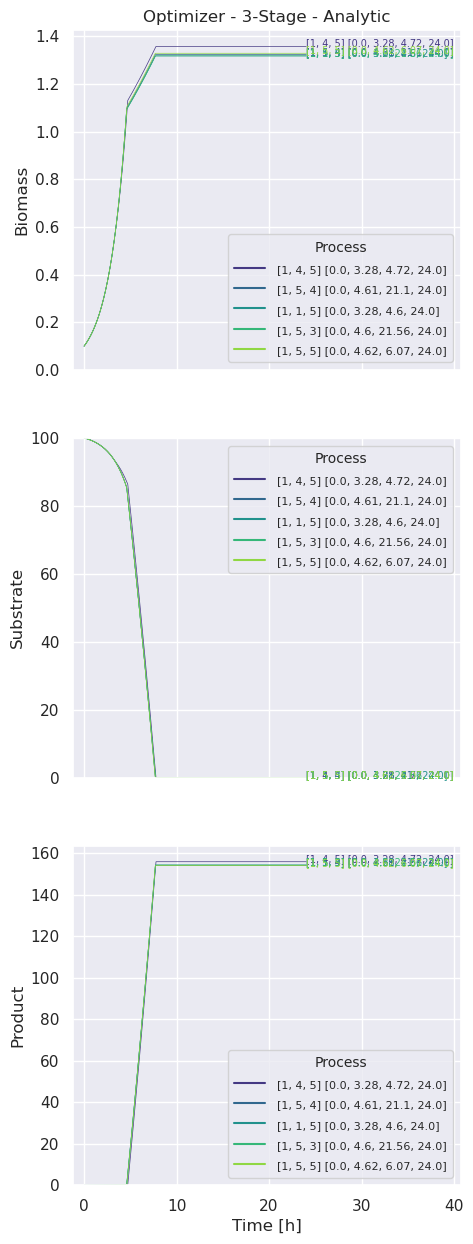

In [41]:
OptimizerAnalytic_3Stage_best = msp.do_opt_to_df(pd.DataFrame(OptimizerAnalytic_3Stage.problem.extract(decorator_problem).dv_log), n_best=5)
msp.do_custom_plot(df=msp.do_convert(OptimizerAnalytic_3Stage_best, models_numeric, 0, 24, s), models_num=models_numeric, s=s, title="Optimizer - 3-Stage - Analytic")

## Three-Stage fermentation (all modules)  - Numeric

In [42]:
%%time
def objective(self, x):
    combi=list(x[(self.max_stage-1):len(x)])
    models=self.models
    s0=self.y
    times=[self.tstart]+list(x[0:(self.max_stage-1)])+[self.tend]
    finished=0
    res=[]
    step=self.step
    while len(times)>1:
        finished= finished+1
        r = sp.integrate.solve_ivp(models[int(combi[0])], t_span=[times[0], times[1]], y0=s0, t_eval=[times[1]], events=[msp.event_sub0, msp.event_prod85percent], dense_output=True, max_step=step)

        try:    # Case in which event triggers and fermentation stopps before tend
            res = [ r.y_events[0][0][species] for species in range(len(s)) ]
            res = res + [r.t_events[0][0]]
        except: # Case in which fermentation runs until tend
            res = [ r.y[species][0] for species in range(len(s)) ]
            res = res + [r.t[0]]
        ## Drop the first element from combination and time
        # e.g.          (0,1,2) and (0.0, 2.0, 3.0, 24.0)
        # will become   (  1,2) and (     2.0, 3.0, 24.0)
        combi.pop(0)
        times.pop(0)

        if((times[0]-res[-1]) < 1e-9):       # next stage 
            if(len(times)==1):              # if t_end is reached -> stop
                res=res+[np.Inf]
                break
            s0=res[:-1]
        else:                               # fermentation finished before last stage        
            res=res+[finished]
            break
    ## Objective
    # max. Vol. Productivity
    score = -res[P]/(res[(len(res)-2)]-self.tstart)  
    return score 

algo_ihs = algorithm(ihs(gen=100000, seed=12345))  # total numer of evaluations = 10 + 1000
algo_ihs.set_verbosity(10000)  # output best performing each 50th generation

OptimizerNumeric_3Stage_Prob = problem(decorator_problem(msp.Optimizer(
            s=s,
            models=models_numeric,
            tstart=0,
            tend=24,
            max_stage=3,
            min_duration=1,
            objective=objective
        ),
        fitness_decorator=msp.f_log_decor,
    )
)
OptimizerNumeric_3Stage_Prob.c_tol = 1e-3

OptimizerNumeric_3Stage = algo_ihs.evolve(population(OptimizerNumeric_3Stage_Prob, size=10, seed=12345))  # start with 10 candidate solutions
#msp.do_save(OptimizerNumeric_3Stage, './Results/Computer_Stg3_num_opt_All.pickle')


Fevals:          ppar:            bw:            dx:            df:      Violated:    Viol. Norm:        ideal1:
      1       0.350006       0.999885        30.0108        9.74457              0              0       -9.74457


  10001       0.414006       0.316191              0              0              0              0       -20.0285
  20001       0.478006      0.0999885              0              0              0              0       -20.0918
  30001       0.542006      0.0316191              0              0              0              0       -20.0919
  40001       0.606006     0.00999885              0              0              0              0       -20.0919
  50001       0.670006     0.00316191              0              0              0              0       -20.0919
  60001       0.734006    0.000999885      0.0177788    6.60878e-06              0              0       -20.0919
  70001       0.798006    0.000316191      0.0035628    4.54677e-06              0              0       -20.0919
  80001       0.862006    9.99885e-05      0.0035628    4.54677e-06              0              0       -20.0919
  90001       0.926006    3.16191e-05     0.00113029    4.84574e-06              0              

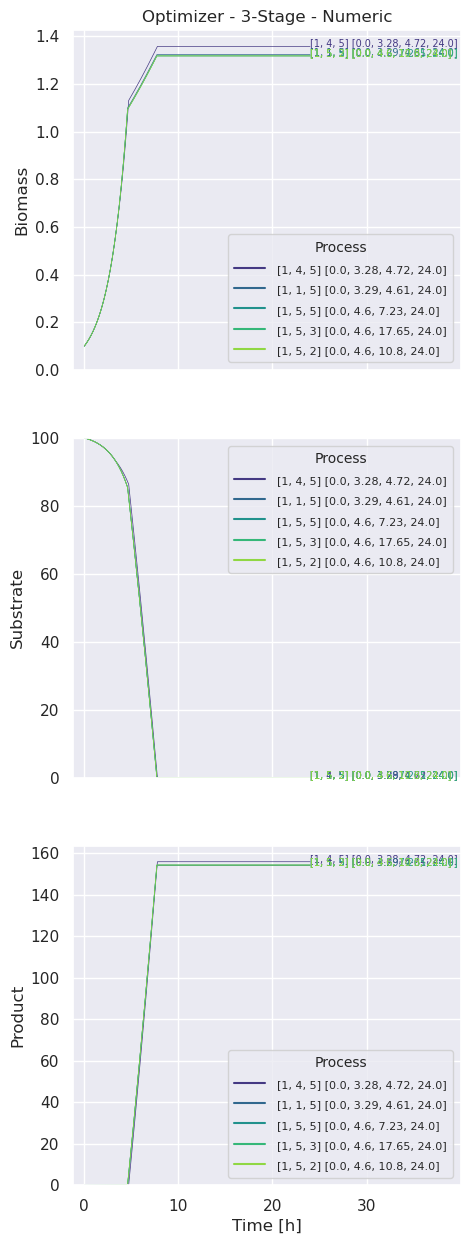

In [43]:
OptimizerNumeric_3Stage_best = msp.do_opt_to_df(pd.DataFrame(OptimizerNumeric_3Stage.problem.extract(decorator_problem).dv_log), n_best=5)
msp.do_custom_plot(df=msp.do_convert(OptimizerNumeric_3Stage_best, models_numeric, 0, 24, s), models_num=models_numeric, s=s, title="Optimizer - 3-Stage - Numeric")

___